## K-Means

### Data Import

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random as rd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [16]:
#reading each xlsx and changing columns to match to then concat
df2014 = pd.read_excel('data/ttc-streetcar-delay-data-2014.xlsx')
df2015 = pd.read_excel('data/ttc-streetcar-delay-data-2015.xlsx')
df2016 = pd.read_excel('data/ttc-streetcar-delay-data-2016.xlsx')
df2017 = pd.read_excel('data/ttc-streetcar-delay-data-2017.xlsx')
df2018 = pd.read_excel('data/ttc-streetcar-delay-data-2018.xlsx')
df2019 = pd.read_excel('data/ttc-streetcar-delay-data-2019.xlsx')
df2020 = pd.read_excel('data/ttc-streetcar-delay-data-2020_final.xlsx').rename(columns={'Delay':'Min Delay',
                                                                                  'Gap':'Min Gap'})
df2021 = pd.read_excel('data/ttc-streetcar-delay-data-jan-2021-to-august-2021.xlsx').rename(columns={'Bound':'Direction',
                                                                                               'Date':'Report Date',
                                                                                               'Line':'Route'})

df2014['Time'] = pd.to_datetime(df2014['Time'], format='%H:%M:%S').dt.time
df2015['Time'] = pd.to_datetime(df2015['Time'], format='%H:%M:%S').dt.time
df2016['Time'] = pd.to_datetime(df2016['Time'], format='%H:%M:%S').dt.time
df2017['Time'] = pd.to_datetime(df2017['Time'], format='%H:%M:%S').dt.time
df2018['Time'] = pd.to_datetime(df2018['Time'], format='%H:%M:%S').dt.time
df2019['Time'] = pd.to_datetime(df2019['Time'], format='%H:%M:%S').dt.time
df2020['Time'] = pd.to_datetime(df2020['Time'], format='%H:%M:%S').dt.time
df2021['Time'] = pd.to_datetime(df2021['Time'], format='%H:%M:%S').dt.time

frames = [df2014, df2015, df2016, df2017, df2018, df2019, df2020, df2021]
df = pd.concat(frames)

In [17]:
df = df.rename(columns={'Report Date':'Report_Date','Min Delay':'Min_Delay','Min Gap':'Min_Gap',
                       'Round Time':'Round_Time'})

### Removing NAs

In [18]:
#summing na values
df.isna().sum()

Report_Date      0
Route            2
Time             0
Day              0
Location        21
Incident         0
Min_Delay        3
Min_Gap          5
Direction       98
Vehicle        503
Round_Time       0
dtype: int64

In [19]:
#removing vehicle as a column
df = df.drop('Vehicle', axis=1)

In [76]:
#removing na values
df = df.dropna().sample(frac = 1)
df

Report_Date Route      Time        Day                       Location  \
242   2017-01-07   512  08:14:00   Saturday                          ronce   
479   2018-01-07   504  18:51:00     Sunday                 jameson_/_king   
994   2016-01-27   506  06:14:00  Wednesday   howard_park_and_roncesvalles   
998   2019-01-24   301  01:03:00   Thursday               queen/parliament   
346   2015-01-09   511  06:06:00     Friday         queen_and_roncesvalles   
...          ...   ...       ...        ...                            ...   
335   2016-01-11   506  07:07:00     Monday                   main_station   
643   2016-01-18   504  06:14:00     Monday                   russell_yard   
774   2020-01-31   509  00:52:00     Friday                     fleet_loop   
631   2017-01-16   506  14:04:00     Monday  coxwell_north_of_gerrard_east   
1246  2019-01-28   501  07:10:00     Monday              queen_&_connaught   

                 Incident  Min_Delay  Min_Gap Direction Round_Time  \
242            mechanical        6.0     12.0       N/B   08:00:00   
479            mechanical        8.0     15.0       E/B   19:00:00   
994            mechanical        6.0     18.0       E/B   06:00:00   
998            mechanical        9.0     18.0       E/B   01:00:00   
346   late_leaving_garage        5.0     10.0       E/B   06:00:00   
...                   ...        ...      ...       ...        ...   
335   late_leaving_garage        4.0      8.0       W/B   07:00:00   
643            mechanical        4.0      8.0       E/B   06:00:00   
774    emergency_services        9.0     18.0       E/B   01:00:00   
631    emergency_services        8.0     13.0       B/W   14:00:00   
1246           mechanical        5.0     10.0       E/B   07:00:00   

      Time_in_minutes  Time_in_hours  
242             494.0       8.233333  
479            1131.0      18.850000  
994             374.0       6.233333  
998              63.0       1.050000  
346             366.0       6.100000  
...               ...            ...  
335             427.0       7.116667  
643             374.0       6.233333  
774              52.0       0.866667  
631             844.0      14.066667  
1246            430.0       7.166667  

[8957 rows x 12 columns]

### Datetime continuous

In [77]:
from datetime import timedelta

time_in_minutes = []
time_in_hours = []

for time in df['Time']:
    delta = timedelta(hours=int(time.strftime('%H')), 
                      minutes=int(time.strftime('%M')), 
                      seconds=int(time.strftime('%S')))
    total_seconds = delta.total_seconds()
    time_in_minutes.append(total_seconds/60)
    time_in_hours.append(total_seconds/60/60)
    
df['Time_in_minutes'] = time_in_minutes
df['Time_in_hours'] = time_in_hours

### K-Means (day as dummy variable)

In [78]:
def clean_text(text):
    text = text.lower()
    text = text.replace(" ", "_")
    return text

df['Location'] = df['Location'].astype(str).apply(clean_text)
df['Incident'] = df['Incident'].astype(str).apply(clean_text)

In [79]:
cat_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Location', 'Incident', 'Min_Gap'], axis=1)
cat_data

Day
242    Saturday
479      Sunday
994   Wednesday
998    Thursday
346      Friday
...         ...
335      Monday
643      Monday
774      Friday
631      Monday
1246     Monday

[8957 rows x 1 columns]

In [80]:
#encoded df
kmeans_dummy = df

for cat in cat_data:
    dummies = pd.get_dummies(cat_data[cat])
    kmeans_dummy = pd.concat([kmeans_dummy, dummies], axis=1)
    kmeans_dummy = kmeans_dummy.drop(cat, axis=1)

kmeans_dummy = kmeans_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Location', 'Incident', 'Time_in_minutes',
                     'Direction', 'Min_Gap'], axis=1)

kmeans_dummy['Min_Delay'] = (kmeans_dummy['Min_Delay'] - kmeans_dummy['Min_Delay'].min()) / (kmeans_dummy['Min_Delay'].max() - kmeans_dummy['Min_Delay'].min())
kmeans_dummy['Time_in_hours'] = (kmeans_dummy['Time_in_hours'] - kmeans_dummy['Time_in_hours'].min()) / (kmeans_dummy['Time_in_hours'].max() - kmeans_dummy['Time_in_hours'].min())

kmeans_dummy

Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
242    0.010000       0.343294       0       0         1       0         0   
479    0.013333       0.785962       0       0         0       1         0   
994    0.010000       0.259903       0       0         0       0         0   
998    0.015000       0.043780       0       0         0       0         1   
346    0.008333       0.254343       1       0         0       0         0   
...         ...            ...     ...     ...       ...     ...       ...   
335    0.006667       0.296734       0       1         0       0         0   
643    0.006667       0.259903       0       1         0       0         0   
774    0.015000       0.036136       1       0         0       0         0   
631    0.013333       0.586518       0       1         0       0         0   
1246   0.008333       0.298819       0       1         0       0         0   

      Tuesday  Wednesday  
242         0          0  
479         0          0  
994         0          1  
998         0          0  
346         0          0  
...       ...        ...  
335         0          0  
643         0          0  
774         0          0  
631         0          0  
1246        0          0  

[8957 rows x 9 columns]

In [81]:
# Try various values of k
sil_scores = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(kmeans_dummy)
    label = clusterer.predict(kmeans_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(kmeans_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label']
best_label

# Present some summary statistics for each clusters
kmeans_dummy.groupby(best_label).mean()


Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0   0.019421       0.548532     0.0     0.0       1.0     0.0       0.0   
1   0.017697       0.470975     0.0     0.0       0.0     0.0       0.0   
2   0.018102       0.490871     0.0     0.0       0.0     0.0       0.0   
3   0.017233       0.489691     1.0     0.0       0.0     0.0       0.0   
4   0.015840       0.501836     0.0     1.0       0.0     0.0       0.0   
5   0.019396       0.491290     0.0     0.0       0.0     0.0       1.0   
6   0.021980       0.499448     0.0     0.0       0.0     1.0       0.0   

   Tuesday  Wednesday  
0      0.0        0.0  
1      1.0        0.0  
2      0.0        1.0  
3      0.0        0.0  
4      0.0        0.0  
5      0.0        0.0  
6      0.0        0.0

In [82]:
kmeans_dummy.groupby(best_label).describe()

Min_Delay                                                                   \
      count      mean       std  min       25%       50%       75%       max   
0    1068.0  0.019421  0.036138  0.0  0.008333  0.011667  0.016667  0.881667   
1    1541.0  0.017697  0.040561  0.0  0.006667  0.010000  0.016667  0.820000   
2    1374.0  0.018102  0.035851  0.0  0.008333  0.010000  0.016667  0.696667   
3    1438.0  0.017233  0.028982  0.0  0.006667  0.010000  0.016667  0.475000   
4    1341.0  0.015840  0.021328  0.0  0.006667  0.010000  0.016667  0.303333   
5    1300.0  0.019396  0.040328  0.0  0.006667  0.010000  0.016667  1.000000   
6     895.0  0.021980  0.050987  0.0  0.010000  0.013333  0.016667  0.836667   

  Time_in_hours            ... Tuesday      Wednesday                      \
          count      mean  ...     75%  max     count mean  std  min  25%   
0        1068.0  0.548532  ...     0.0  0.0    1068.0  0.0  0.0  0.0  0.0   
1        1541.0  0.470975  ...     1.0  1.0    1541.0  0.0  0.0  0.0  0.0   
2        1374.0  0.490871  ...     0.0  0.0    1374.0  1.0  0.0  1.0  1.0   
3        1438.0  0.489691  ...     0.0  0.0    1438.0  0.0  0.0  0.0  0.0   
4        1341.0  0.501836  ...     0.0  0.0    1341.0  0.0  0.0  0.0  0.0   
5        1300.0  0.491290  ...     0.0  0.0    1300.0  0.0  0.0  0.0  0.0   
6         895.0  0.499448  ...     0.0  0.0     895.0  0.0  0.0  0.0  0.0   

                  
   50%  75%  max  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  1.0  1.0  1.0  
3  0.0  0.0  0.0  
4  0.0  0.0  0.0  
5  0.0  0.0  0.0  
6  0.0  0.0  0.0  

[7 rows x 72 columns]

For k = 5 The average silhouette_score is : 0.612302781672081
For k = 6 The average silhouette_score is : 0.7208251823890026
For k = 7 The average silhouette_score is : 0.8080954823444464
For k = 8 The average silhouette_score is : 0.7808876562301295
For k = 9 The average silhouette_score is : 0.7555530730528117
For k = 10 The average silhouette_score is : 0.7329626618074301
For k = 11 The average silhouette_score is : 0.7102381081304289
For k = 12 The average silhouette_score is : 0.6853141543461627
For k = 13 The average silhouette_score is : 0.6554074180638135
For k = 14 The average silhouette_score is : 0.635391654862762


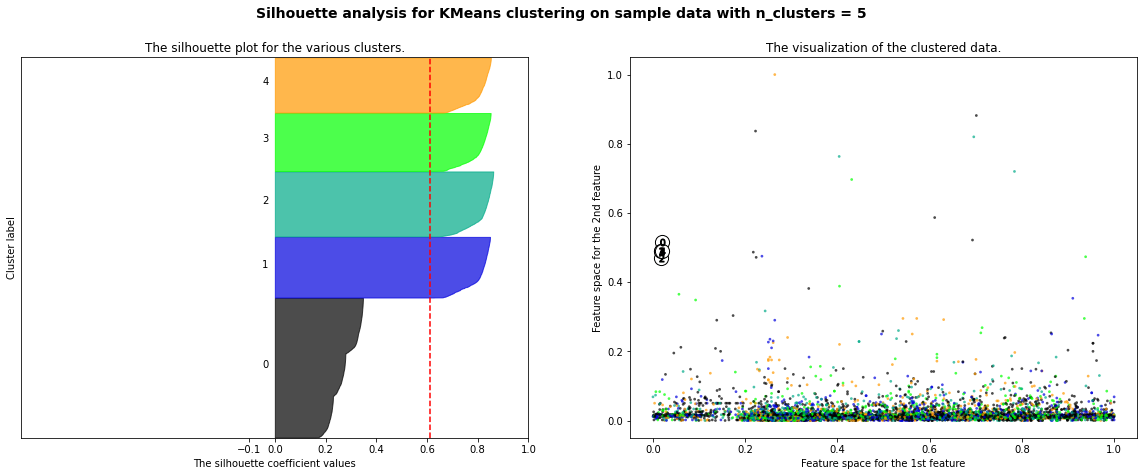

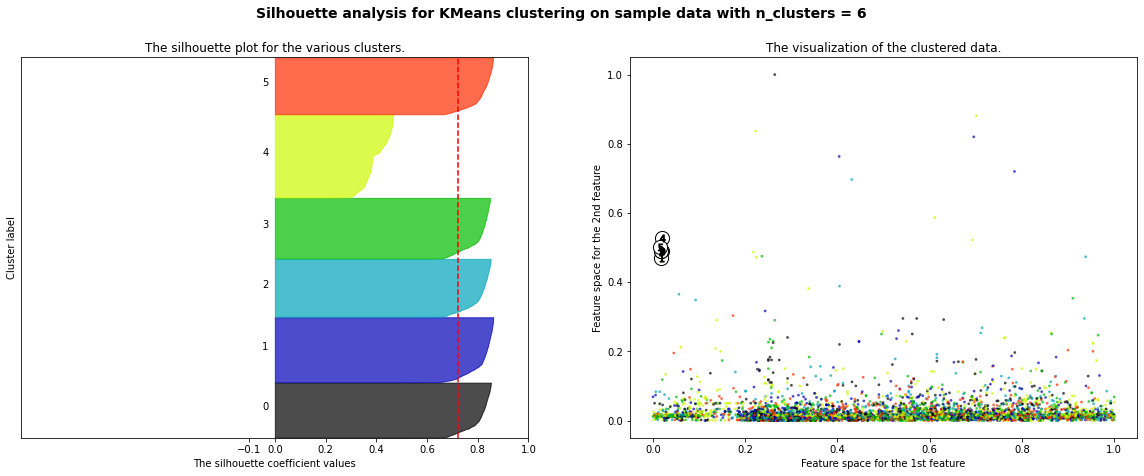

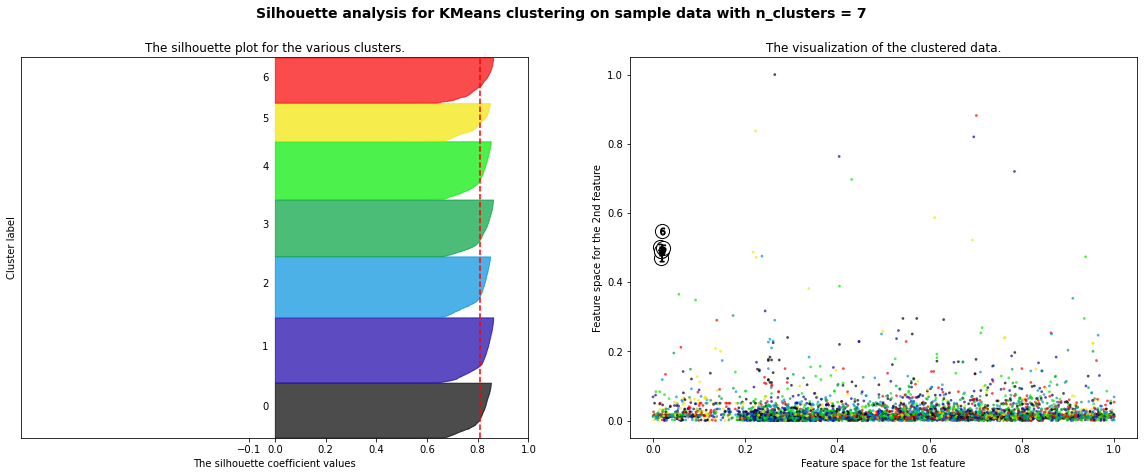

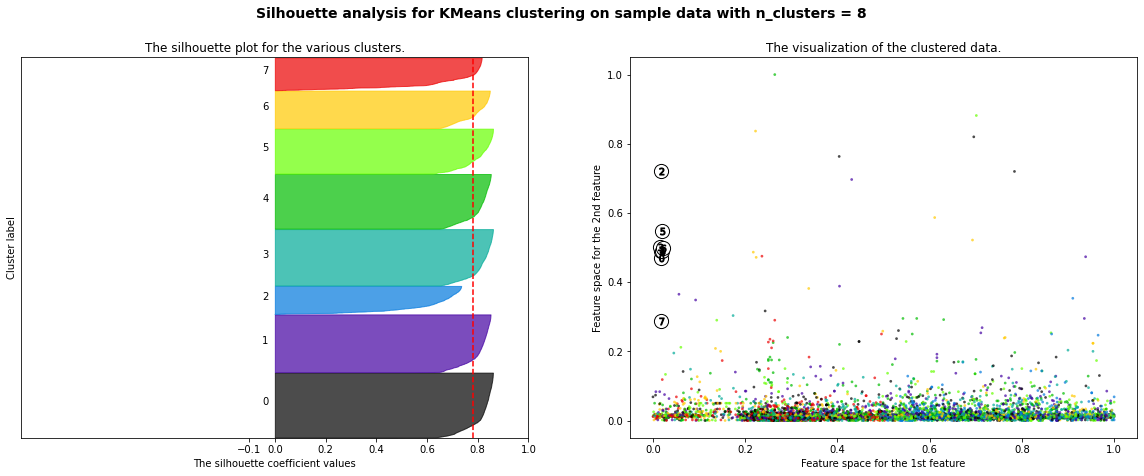

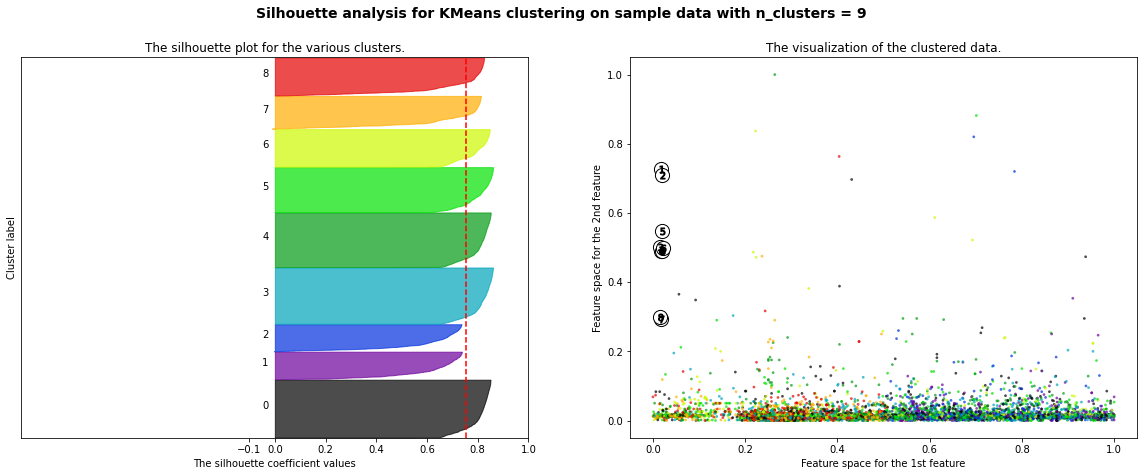

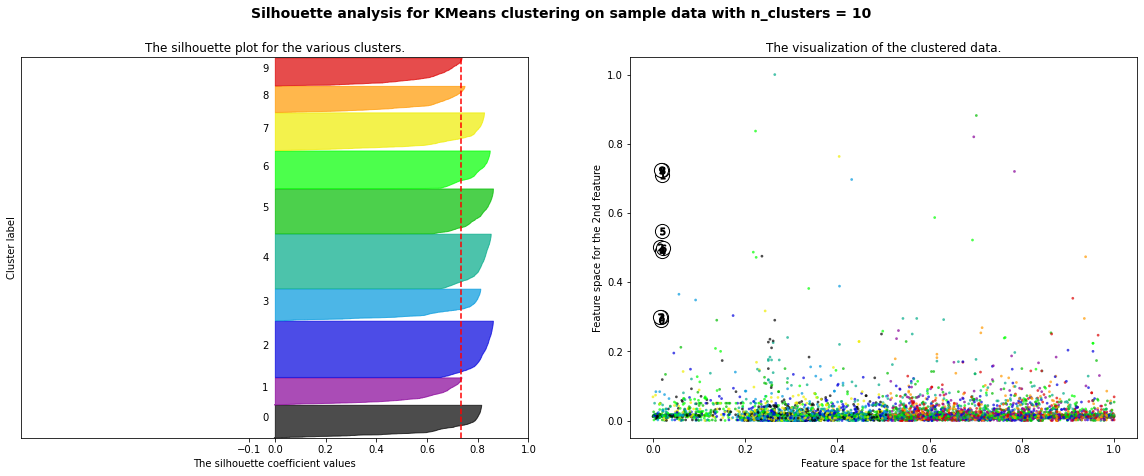

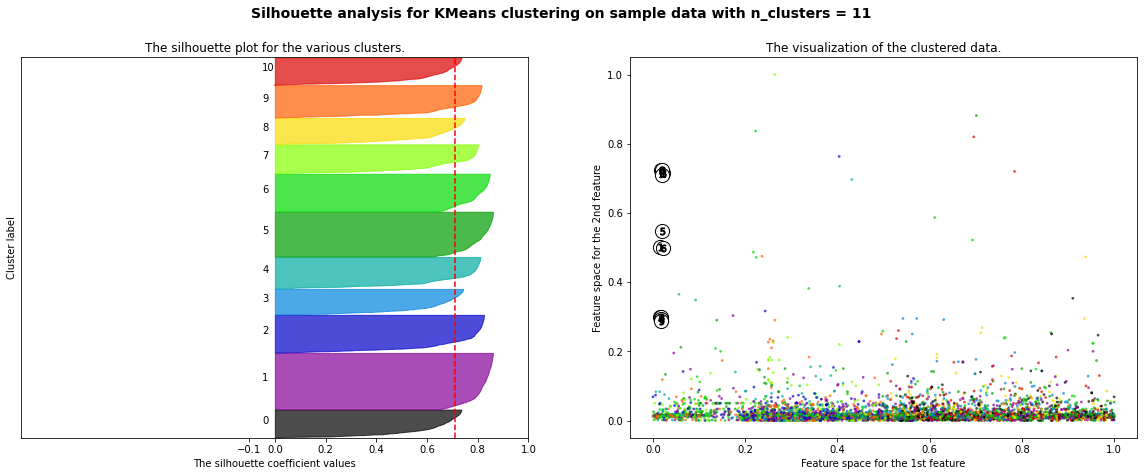

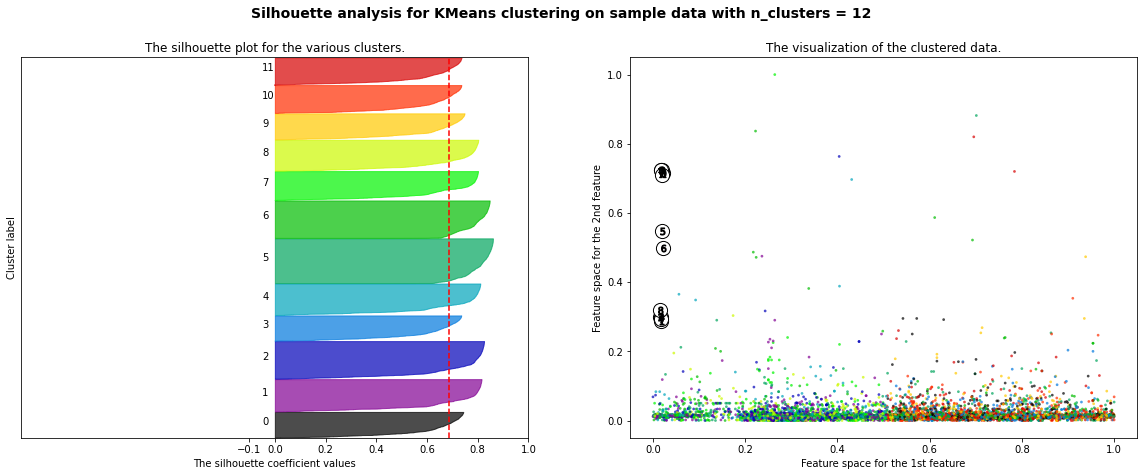

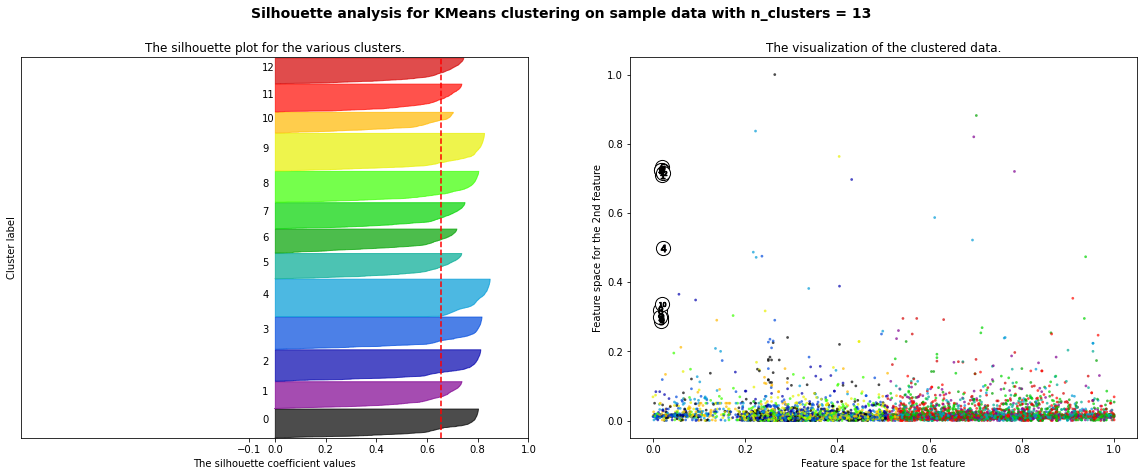

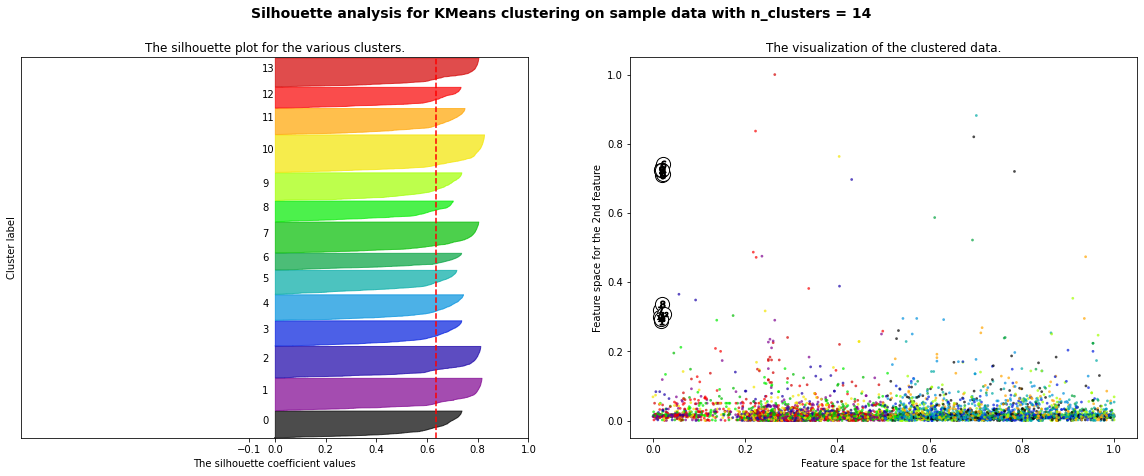

In [83]:
X, y = kmeans_dummy['Time_in_hours'], kmeans_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(kmeans_dummy)
    cluster_labels = clusterer.predict(kmeans_dummy)
    
    silhouette_avg = silhouette_score(kmeans_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(kmeans_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        kmeans_dummy['Time_in_hours'], kmeans_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

### K-Means (location as dummy variable)

In [84]:
location_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction', 'Day',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Incident', 'Min_Gap'], axis=1)
location_data

Location
242                           ronce
479                  jameson_/_king
994    howard_park_and_roncesvalles
998                queen/parliament
346          queen_and_roncesvalles
...                             ...
335                    main_station
643                    russell_yard
774                      fleet_loop
631   coxwell_north_of_gerrard_east
1246              queen_&_connaught

[8957 rows x 1 columns]

In [85]:
#encoded df
location_dummy = df

for i in location_data:
    dummies = pd.get_dummies(location_data[i])
    location_dummy = pd.concat([location_dummy, dummies], axis=1)
    location_dummy = location_dummy.drop(cat, axis=1)

location_dummy = location_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Incident', 
                                      'Time_in_minutes','Direction', 'Min_Gap', 'Location'], axis=1)

location_dummy['Min_Delay'] = (location_dummy['Min_Delay'] - location_dummy['Min_Delay'].min()) / (location_dummy['Min_Delay'].max() - location_dummy['Min_Delay'].min())
location_dummy['Time_in_hours'] = (location_dummy['Time_in_hours'] - location_dummy['Time_in_hours'].min()) / (location_dummy['Time_in_hours'].max() - location_dummy['Time_in_hours'].min())

location_dummy


Min_Delay  Time_in_hours  1st_and_lakeshore  24_th_street_and_lakeshore  \
242    0.010000       0.343294                  0                           0   
479    0.013333       0.785962                  0                           0   
994    0.010000       0.259903                  0                           0   
998    0.015000       0.043780                  0                           0   
346    0.008333       0.254343                  0                           0   
...         ...            ...                ...                         ...   
335    0.006667       0.296734                  0                           0   
643    0.006667       0.259903                  0                           0   
774    0.015000       0.036136                  0                           0   
631    0.013333       0.586518                  0                           0   
1246   0.008333       0.298819                  0                           0   

      28th_street_and_lakeshore  37th_/_lakeshore  37th_street_and_lakeshore  \
242                           0                 0                          0   
479                           0                 0                          0   
994                           0                 0                          0   
998                           0                 0                          0   
346                           0                 0                          0   
...                         ...               ...                        ...   
335                           0                 0                          0   
643                           0                 0                          0   
774                           0                 0                          0   
631                           0                 0                          0   
1246                          0                 0                          0   

      40th_/_lakeshore  506_carlton  5th_/_lakeshore  ...  york/_queen  \
242                  0            0                0  ...            0   
479                  0            0                0  ...            0   
994                  0            0                0  ...            0   
998                  0            0                0  ...            0   
346                  0            0                0  ...            0   
...                ...          ...              ...  ...          ...   
335                  0            0                0  ...            0   
643                  0            0                0  ...            0   
774                  0            0                0  ...            0   
631                  0            0                0  ...            0   
1246                 0            0                0  ...            0   

      york_/_adelaide  york_/_king  york_/_queen  york_and_king  \
242                 0            0             0              0   
479                 0            0             0              0   
994                 0            0             0              0   
998                 0            0             0              0   
346                 0            0             0              0   
...               ...          ...           ...            ...   
335                 0            0             0              0   
643                 0            0             0              0   
774                 0            0             0              0   
631                 0            0             0              0   
1246                0            0             0              0   

      york_and_queen  york_and_queens_quay  york_and_queensquay  \
242                0                     0                    0   
479                0                     0                    0   
994                0                     0                    0   
998                0                     0                    0   
346                0                     0 

In [86]:
# Try various values of k
sil_scores = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(location_dummy)
    label = clusterer.predict(location_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(location_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] 
best_label

# Present some summary statistics for each clusters
location_dummy.groupby(best_label).mean()


Min_Delay  Time_in_hours  1st_and_lakeshore  24_th_street_and_lakeshore  \
0    0.011783       0.547483           0.000000                    0.000000   
1    0.026320       0.293738           0.000000                    0.000000   
2    0.016781       0.321860           0.000000                    0.000000   
3    0.024712       0.129606           0.000000                    0.000000   
4    0.010738       0.378512           0.000000                    0.000000   
5    0.010254       0.338238           0.000000                    0.000000   
6    0.011950       0.400455           0.000000                    0.000000   
7    0.021305       0.840894           0.000000                    0.000000   
8    0.009502       0.391157           0.000000                    0.000000   
9    0.009673       0.325978           0.000000                    0.000000   
10   0.013690       0.543624           0.000000                    0.000000   
11   0.019461       0.594054           0.000439                    0.000439   
12   0.011519       0.594937           0.000000                    0.000000   
13   0.012069       0.466882           0.000000                    0.000000   

    28th_street_and_lakeshore  37th_/_lakeshore  37th_street_and_lakeshore  \
0                    0.000000          0.000000                   0.000000   
1                    0.000000          0.000000                   0.000000   
2                    0.000000          0.000000                   0.000000   
3                    0.000000          0.000000                   0.000000   
4                    0.000000          0.000000                   0.000000   
5                    0.000000          0.000000                   0.000000   
6                    0.000000          0.000000                   0.000000   
7                    0.000000          0.000000                   0.000000   
8                    0.000000          0.000000                   0.000000   
9                    0.000000          0.000000                   0.000000   
10                   0.000000          0.000000                   0.000000   
11                   0.000439          0.000439                   0.000439   
12                   0.000000          0.000000                   0.000000   
13                   0.000000          0.000000                   0.000000   

    40th_/_lakeshore  506_carlton  5th_/_lakeshore  ...  york/_queen  \
0           0.000000     0.000000         0.000000  ...     0.000000   
1           0.000000     0.000000         0.000000  ...     0.000000   
2           0.000000     0.000000         0.000373  ...     0.000000   
3           0.000000     0.000000         0.000000  ...     0.000000   
4           0.000000     0.000000         0.000000  ...     0.000000   
5           0.000000     0.000000         0.000000  ...     0.000000   
6           0.000000     0.000000         0.000000  ...     0.000000   
7           0.000000     0.001704         0.000000  ...     0.000568   
8           0.000000     0.000000         0.000000  ...     0.000000   
9           0.000000     0.000000         0.000000  ...     0.000000   
10          0.000000     0.000000         0.000000  ...     0.000000   
11          0.000439     0.001757         0.000000  ...     0.000000   
12          0.000000     0.000000         0.000000  ...     0.000000   
13          0.000000     0.000000         0.000000  ...     0.000000   

    york_/_adelaide  york_/_king  york_/_queen  york_and_king  york_and_queen  \
0          0.000000     0.000000      0.000000       0.000000        0.000000   
1          0.000000     0.000000      0.000000       0.000000        0.000000   
2          0.000000     0.000373      0.000373       0.000373        0.000000   
3          0.000000     0.000000      0.000000       0.000000        0.000000   
4          0.000000     0.000000      0.000000       0.000000        0.000000   
5          0.000000     0.000000      0.000000       0.000000        0.000000   

In [87]:
location_dummy.groupby(best_label).describe()

Min_Delay                                                              \
       count      mean       std       min       25%       50%       75%   
0      157.0  0.011783  0.008603  0.001667  0.008333  0.010000  0.013333   
1      231.0  0.026320  0.078300  0.000000  0.005000  0.013333  0.015000   
2     2680.0  0.016781  0.037178  0.000000  0.006667  0.010000  0.016667   
3      631.0  0.024712  0.036406  0.000000  0.010000  0.015000  0.025000   
4      140.0  0.010738  0.005082  0.000000  0.008333  0.008333  0.013333   
5      131.0  0.010254  0.005023  0.001667  0.008333  0.010000  0.010000   
6       47.0  0.011950  0.011013  0.003333  0.006667  0.008333  0.014167   
7     1761.0  0.021305  0.035255  0.000000  0.008333  0.011667  0.018333   
8      184.0  0.009502  0.005408  0.000000  0.006667  0.008333  0.010000   
9      245.0  0.009673  0.005095  0.000000  0.006667  0.010000  0.010000   
10     182.0  0.013690  0.013828  0.000000  0.006667  0.010000  0.013333   
11    2277.0  0.019461  0.039635  0.000000  0.008333  0.010000  0.016667   
12     113.0  0.011519  0.015847  0.000000  0.006667  0.010000  0.015000   
13     178.0  0.012069  0.011056  0.000000  0.006667  0.008333  0.013333   

             Time_in_hours            ... young_and_dundas       yoyoma  \
         max         count      mean  ...              75%  max   count   
0   0.068333         157.0  0.547483  ...              0.0  0.0   157.0   
1   1.000000         231.0  0.293738  ...              0.0  0.0   231.0   
2   0.836667        2680.0  0.321860  ...              0.0  0.0  2680.0   
3   0.365000         631.0  0.129606  ...              0.0  0.0   631.0   
4   0.036667         140.0  0.378512  ...              0.0  0.0   140.0   
5   0.040000         131.0  0.338238  ...              0.0  0.0   131.0   
6   0.073333          47.0  0.400455  ...              0.0  0.0    47.0   
7   0.720000        1761.0  0.840894  ...              0.0  1.0  1761.0   
8   0.028333         184.0  0.391157  ...              0.0  0.0   184.0   
9   0.038333         245.0  0.325978  ...              0.0  0.0   245.0   
10  0.070000         182.0  0.543624  ...              0.0  0.0   182.0   
11  0.881667        2277.0  0.594054  ...              0.0  0.0  2277.0   
12  0.156667         113.0  0.594937  ...              0.0  0.0   113.0   
13  0.083333         178.0  0.466882  ...              0.0  0.0   178.0   

                                                 
        mean       std  min  25%  50%  75%  max  
0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
1   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
2   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
3   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
4   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
5   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
6   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
7   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
8   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
9   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
10  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
11  0.000439  0.020956  0.0  0.0  0.0  0.0  1.0  
12  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
13  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  

[14 rows x 22864 columns]

For k = 5 The average silhouette_score is : 0.07199170737922364
For k = 6 The average silhouette_score is : 0.0655109851480231
For k = 7 The average silhouette_score is : 0.08829519700655244
For k = 8 The average silhouette_score is : 0.10061978119432806
For k = 9 The average silhouette_score is : 0.11568964951747888
For k = 10 The average silhouette_score is : 0.12320464425524784
For k = 11 The average silhouette_score is : 0.12459818248575019
For k = 12 The average silhouette_score is : 0.14393847002813503
For k = 13 The average silhouette_score is : 0.1424072638836349
For k = 14 The average silhouette_score is : 0.14348897468887825


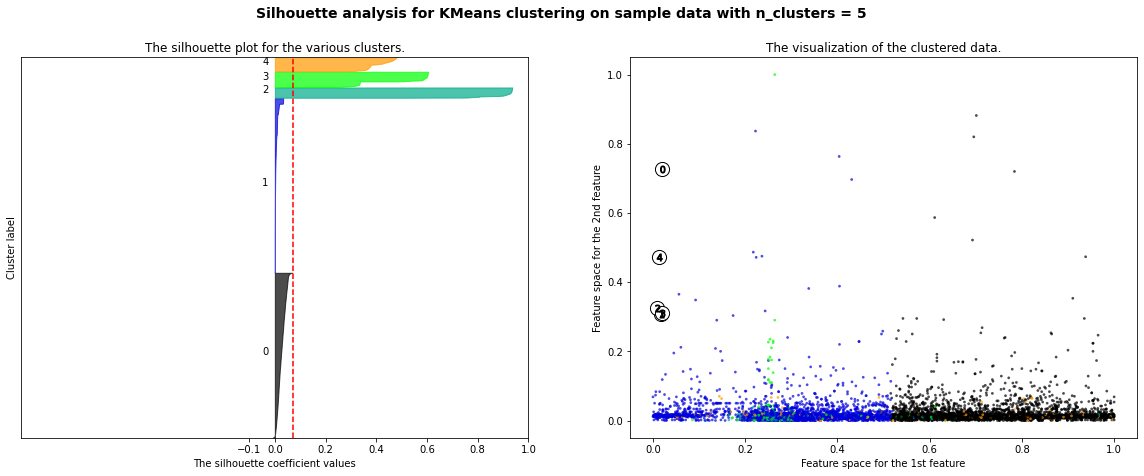

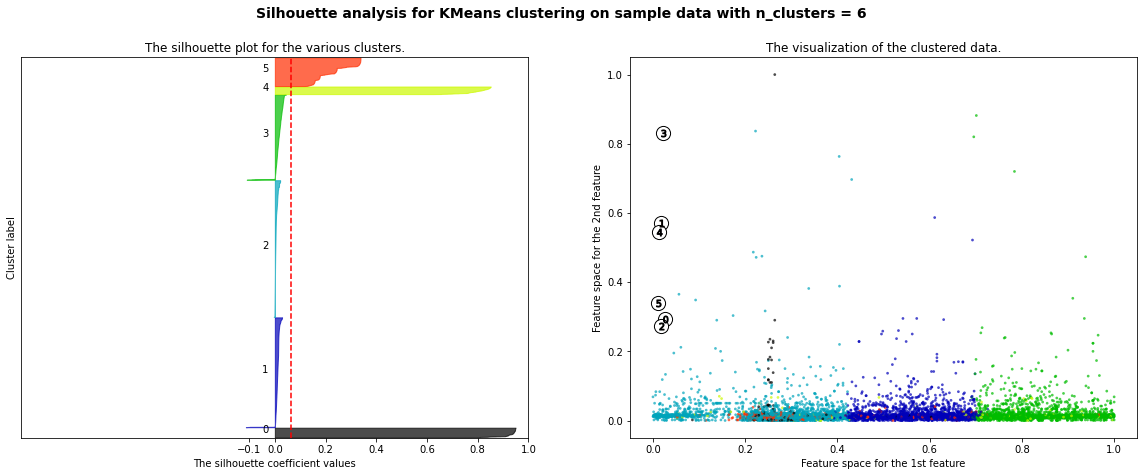

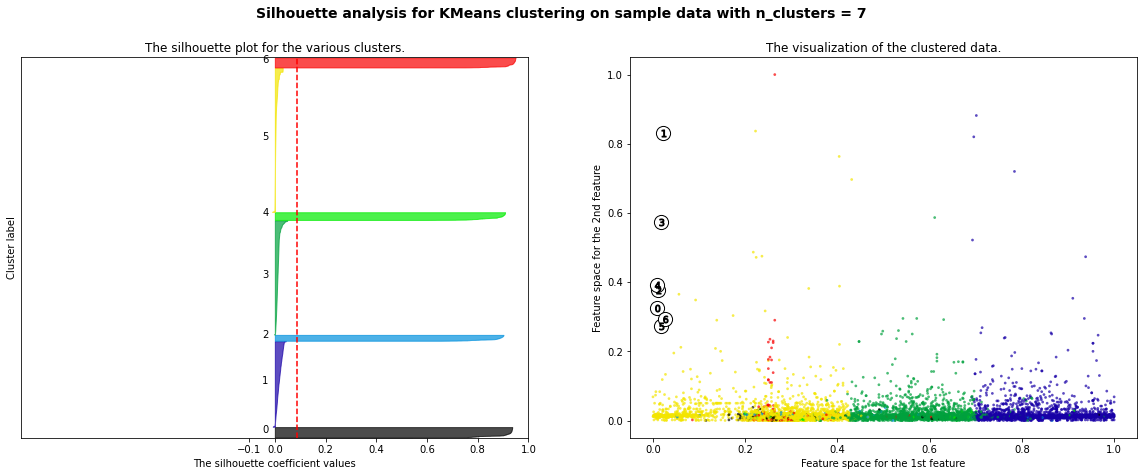

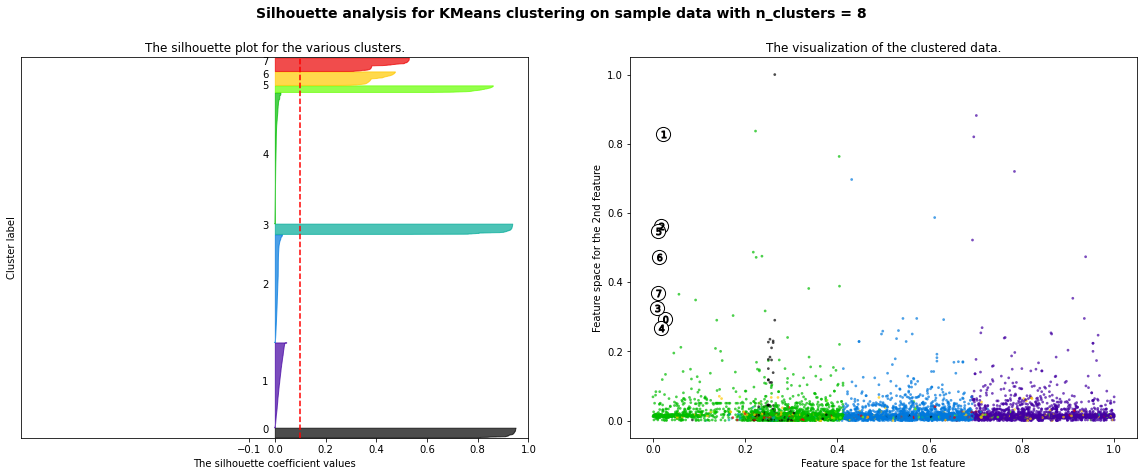

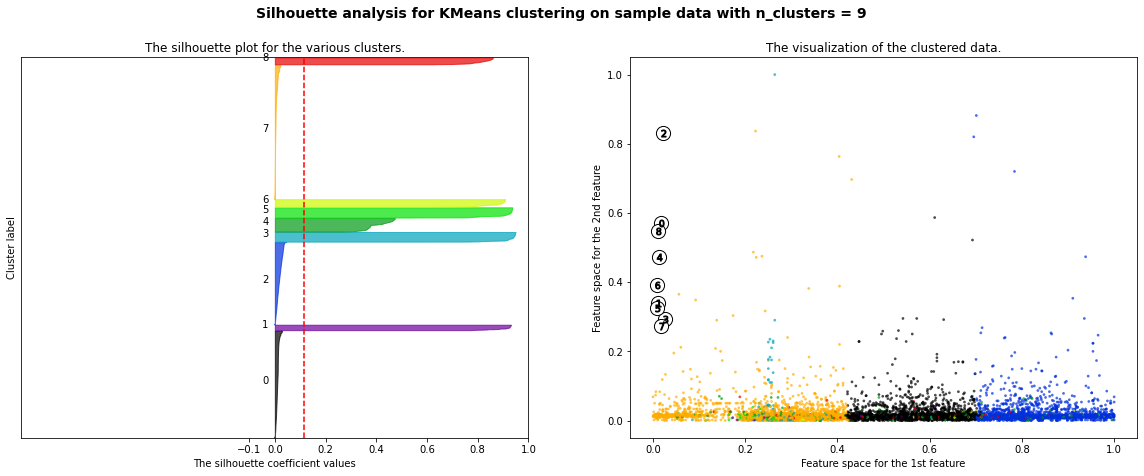

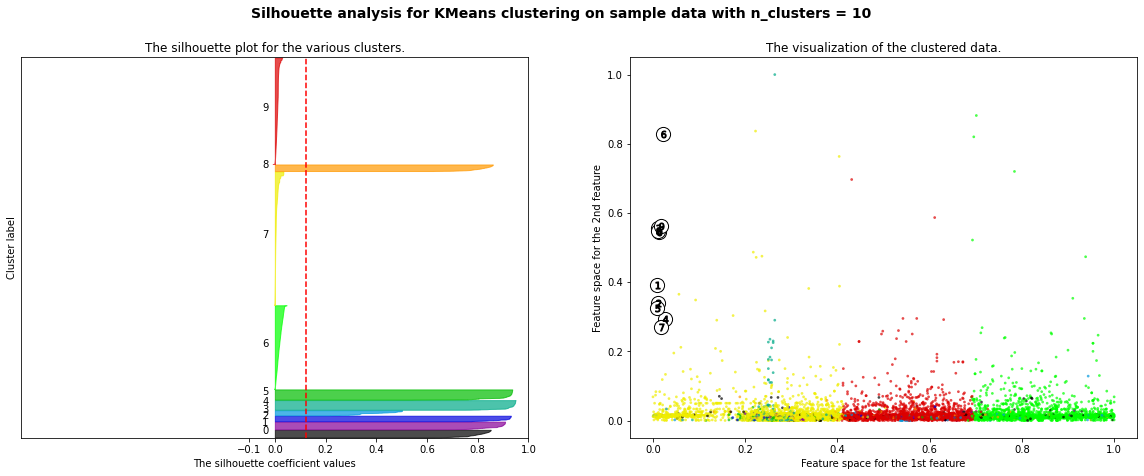

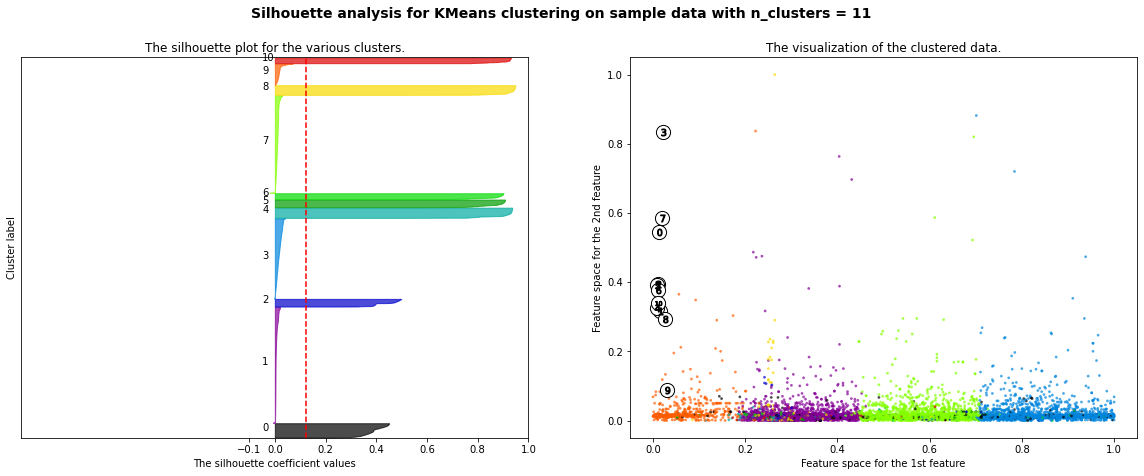

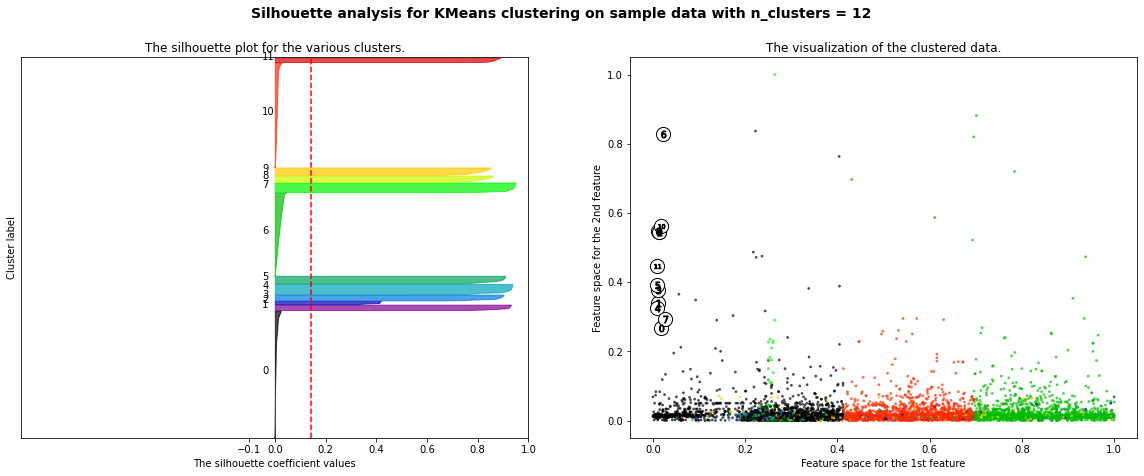

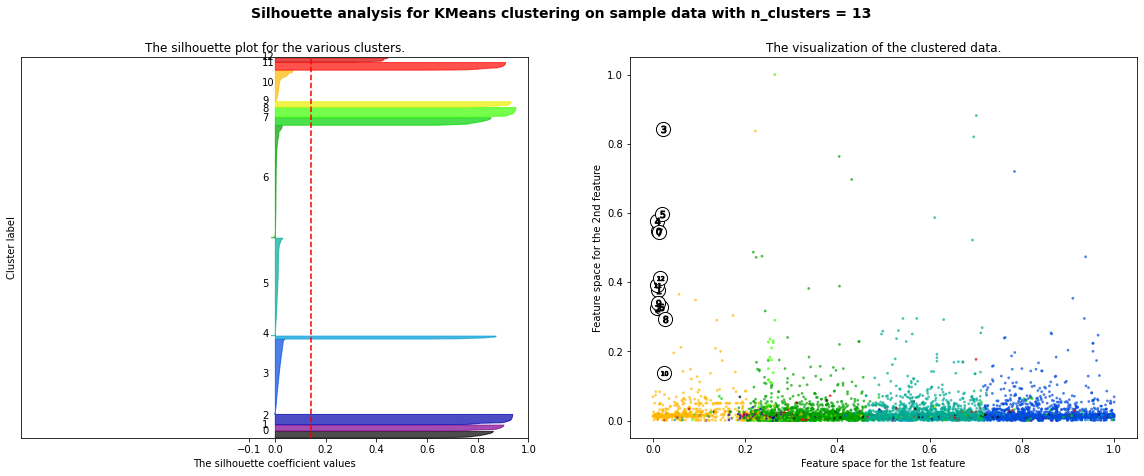

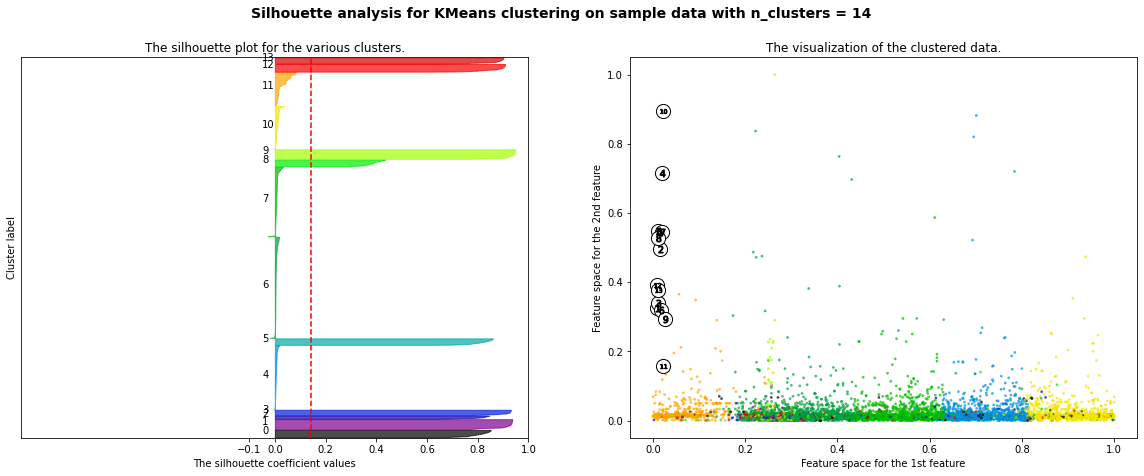

In [88]:
X, y = location_dummy['Time_in_hours'], location_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(location_dummy)
    cluster_labels = clusterer.predict(location_dummy)
    
    silhouette_avg = silhouette_score(location_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(location_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        location_dummy['Time_in_hours'], location_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

### K-Means (incident as dummy variables)

In [89]:
incident_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction', 'Day',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Location', 'Min_Gap'], axis=1)
incident_data

Incident
242            mechanical
479            mechanical
994            mechanical
998            mechanical
346   late_leaving_garage
...                   ...
335   late_leaving_garage
643            mechanical
774    emergency_services
631    emergency_services
1246           mechanical

[8957 rows x 1 columns]

In [90]:
#encoded df
incident_dummy = df

for i in incident_data:
    dummies = pd.get_dummies(incident_data[i])
    incident_dummy = pd.concat([incident_dummy, dummies], axis=1)
    incident_dummy = incident_dummy.drop(i, axis=1)

incident_dummy = incident_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Day',
                                      'Time_in_minutes','Direction', 'Min_Gap', 'Location'], axis=1)

incident_dummy['Min_Delay'] = (incident_dummy['Min_Delay'] - incident_dummy['Min_Delay'].min()) / (incident_dummy['Min_Delay'].max() - incident_dummy['Min_Delay'].min())
incident_dummy['Time_in_hours'] = (incident_dummy['Time_in_hours'] - incident_dummy['Time_in_hours'].min()) / (incident_dummy['Time_in_hours'].max() - incident_dummy['Time_in_hours'].min())

incident_dummy


Min_Delay  Time_in_hours  cleaning  collision_-_ttc_involved  diversion  \
242    0.010000       0.343294         0                         0          0   
479    0.013333       0.785962         0                         0          0   
994    0.010000       0.259903         0                         0          0   
998    0.015000       0.043780         0                         0          0   
346    0.008333       0.254343         0                         0          0   
...         ...            ...       ...                       ...        ...   
335    0.006667       0.296734         0                         0          0   
643    0.006667       0.259903         0                         0          0   
774    0.015000       0.036136         0                         0          0   
631    0.013333       0.586518         0                         0          0   
1246   0.008333       0.298819         0                         0          0   

      emergency_services  general_delay  held_by  investigation  late  \
242                    0              0        0              0     0   
479                    0              0        0              0     0   
994                    0              0        0              0     0   
998                    0              0        0              0     0   
346                    0              0        0              0     0   
...                  ...            ...      ...            ...   ...   
335                    0              0        0              0     0   
643                    0              0        0              0     0   
774                    1              0        0              0     0   
631                    1              0        0              0     0   
1246                   0              0        0              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
242                     0           1           0         0   
479                     0           1           0         0   
994                     0           1           0         0   
998                     0           1           0         0   
346                     1           0           0         0   
...                   ...         ...         ...       ...   
335                     1           0           0         0   
643                     0           1           0         0   
774                     0           0           0         0   
631                     0           0           0         0   
1246                    0           1           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
242                       0              0         0                   0  
479                       0              0         0                   0  
994                       0              0         0                   0  
998                       0              0         0                   0  
346                       0              0         0                   0  
...                     ...            ...       ...                 ...  
335                       0              0         0                   0  
643                       0              0         0                   0  
774                       0              0         0                   0  
631                       0              0         0                   0  
1246                      0              0         0                   0  

[8957 rows x 18 columns]

In [91]:
# Try various values of k
sil_scores = []
for k in range(2,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(incident_dummy)
    label = clusterer.predict(incident_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(incident_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] 
best_label

# Present some summary statistics for each clusters
#location_dummy.groupby(best_label).mean()
sil_scores

k  silhouette_score                                              label
0    2          0.473560  [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, ...
1    3          0.560442  [0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 2, 0, 0, 0, 1, ...
2    4          0.636556  [0, 0, 0, 0, 3, 1, 2, 0, 1, 1, 3, 0, 0, 0, 2, ...
3    5          0.697800  [0, 0, 0, 0, 1, 3, 2, 0, 4, 3, 1, 0, 0, 0, 2, ...
4    6          0.728958  [0, 0, 0, 0, 2, 1, 3, 0, 4, 1, 2, 0, 0, 0, 3, ...
5    7          0.754590  [0, 0, 0, 0, 3, 1, 2, 0, 4, 1, 3, 0, 0, 0, 2, ...
6    8          0.776761  [2, 2, 2, 2, 3, 1, 0, 2, 5, 1, 3, 2, 2, 2, 0, ...
7    9          0.793132  [1, 1, 1, 1, 0, 4, 2, 1, 3, 4, 0, 1, 1, 1, 2, ...
8   10          0.706722  [9, 0, 9, 9, 2, 3, 1, 9, 6, 3, 2, 0, 0, 9, 1, ...
9   11          0.718533  [0, 9, 0, 0, 2, 4, 1, 0, 5, 4, 2, 9, 9, 0, 1, ...
10  12          0.724232  [6, 0, 6, 6, 3, 2, 1, 6, 5, 2, 3, 0, 0, 6, 1, ...
11  13          0.728055  [0, 9, 0, 0, 4, 1, 3, 0, 5, 1, 4, 9, 9, 0, 3, ...
12  14          0.703909  [8, 1, 8, 8, 3, 4, 11, 8, 5, 4, 3, 1, 1, 8, 11...

For k = 2 The average silhouette_score is : 0.4735604991301107
For k = 3 The average silhouette_score is : 0.5604421871230412
For k = 4 The average silhouette_score is : 0.6365556950834428
For k = 5 The average silhouette_score is : 0.6977998860054281
For k = 6 The average silhouette_score is : 0.728957929009116
For k = 7 The average silhouette_score is : 0.7545898669358184
For k = 8 The average silhouette_score is : 0.7767610901185578
For k = 9 The average silhouette_score is : 0.7931321635091473
For k = 10 The average silhouette_score is : 0.7067221638924212
For k = 11 The average silhouette_score is : 0.718533354584001
For k = 12 The average silhouette_score is : 0.7237160527020352
For k = 13 The average silhouette_score is : 0.7280548696061071
For k = 14 The average silhouette_score is : 0.7039086193230603


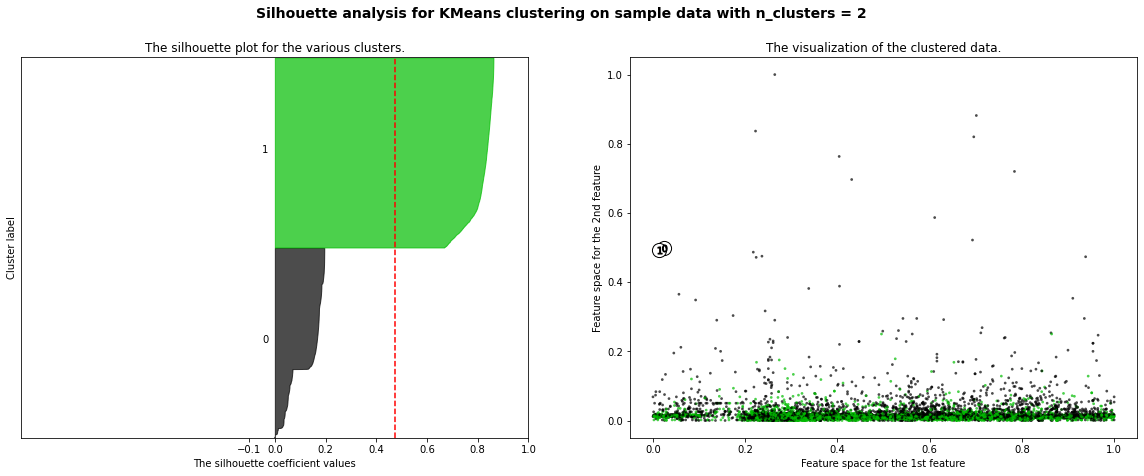

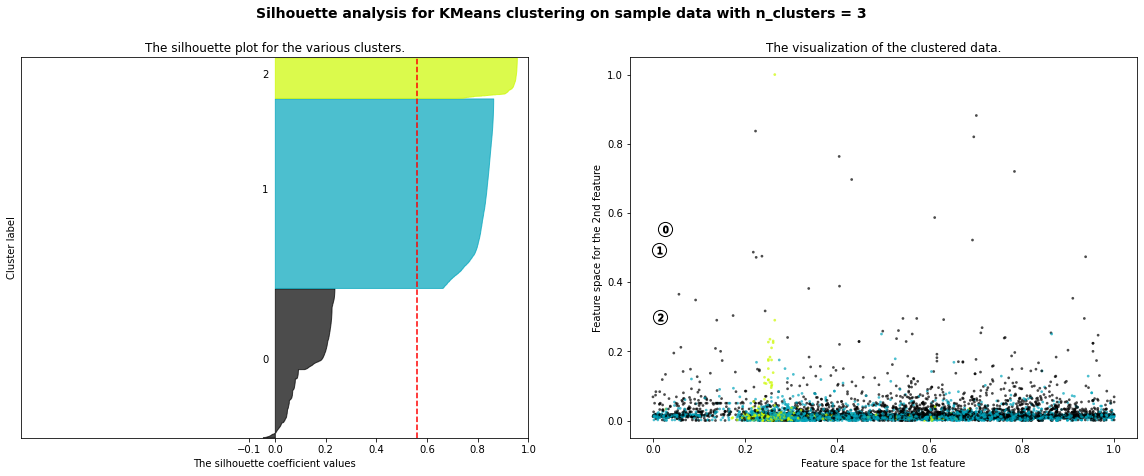

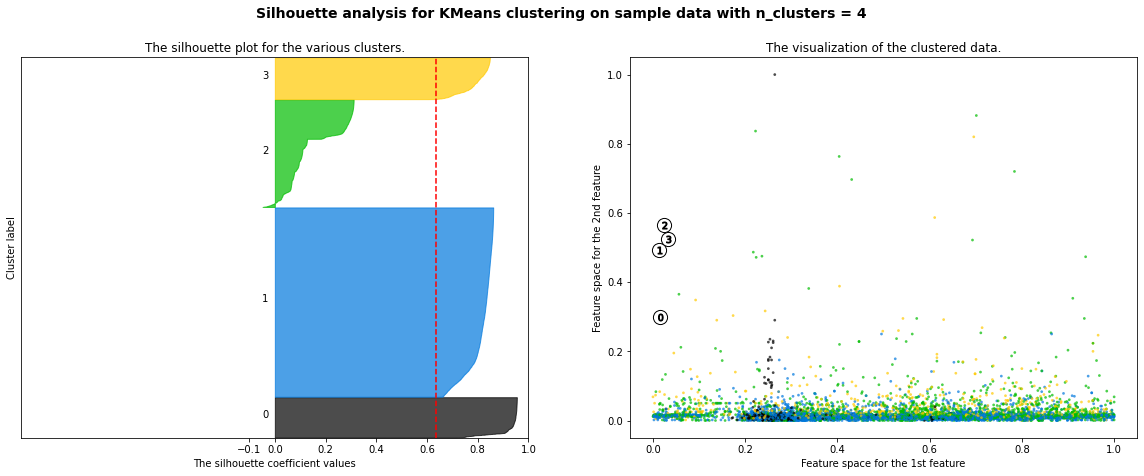

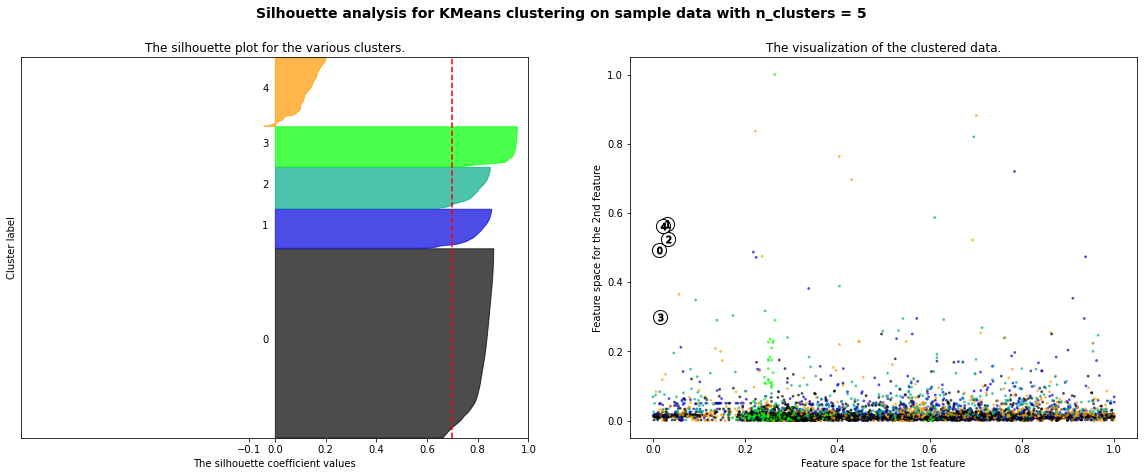

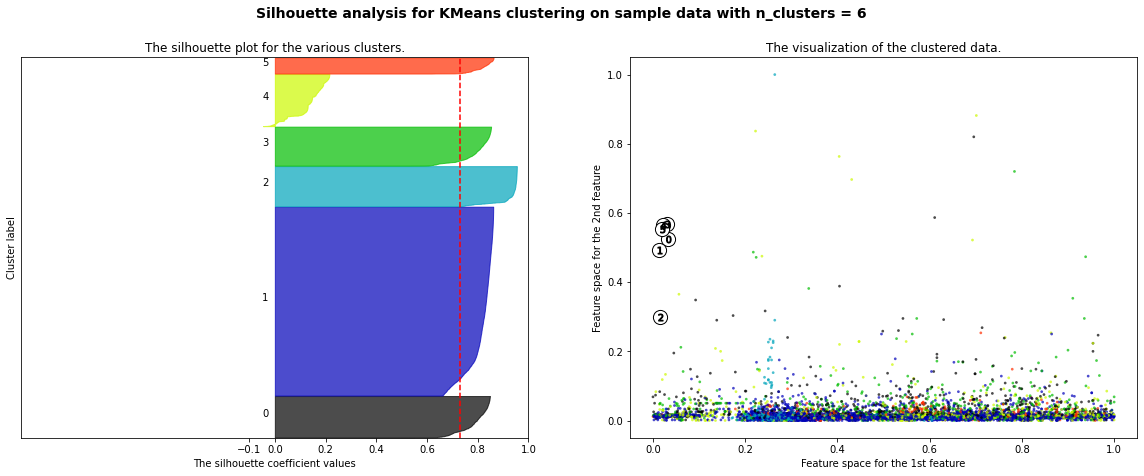

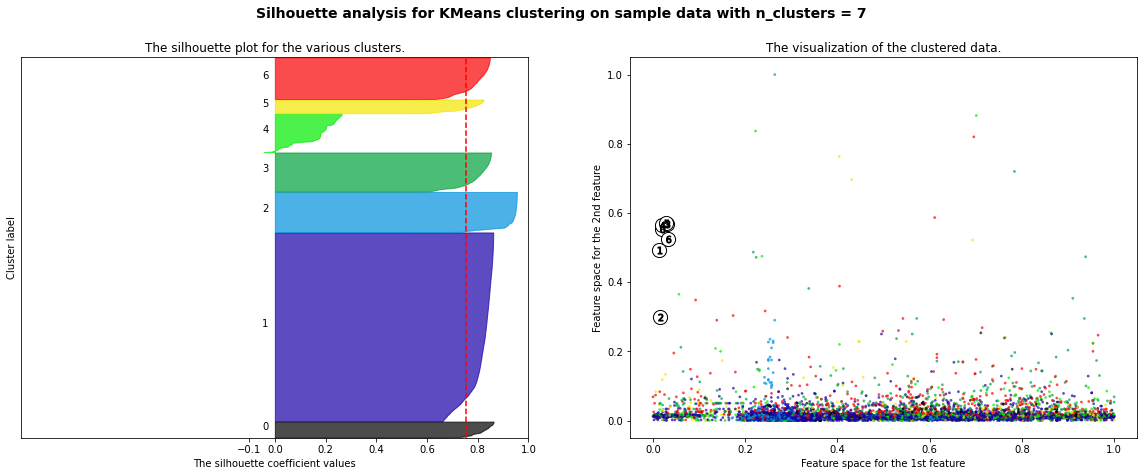

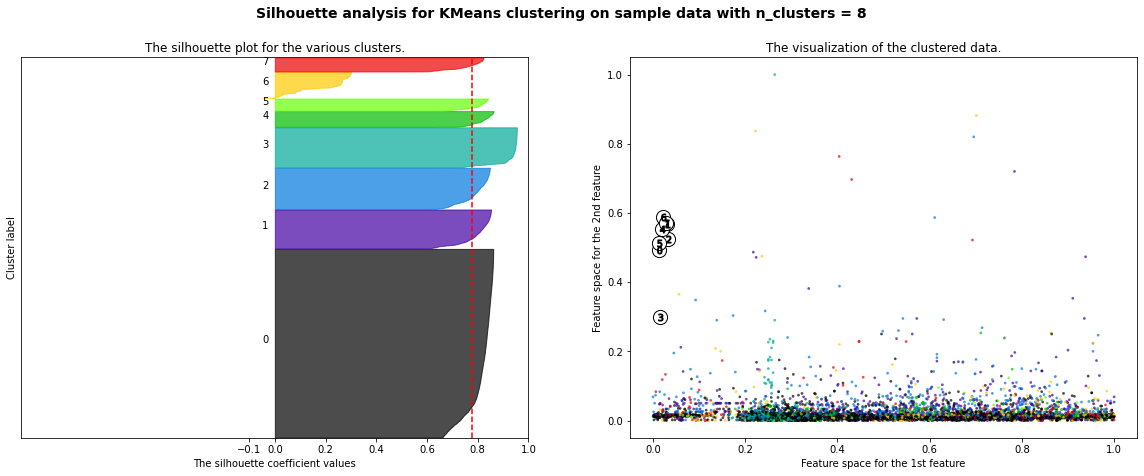

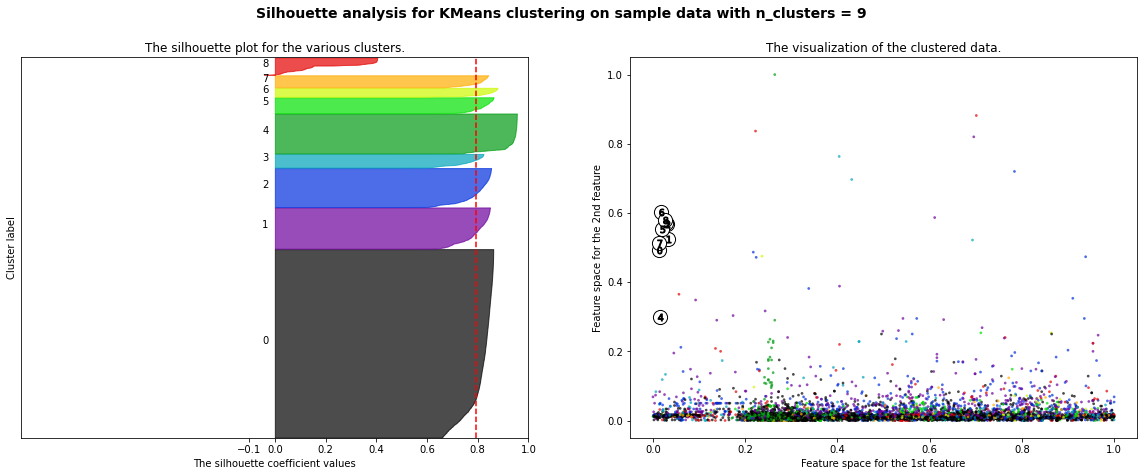

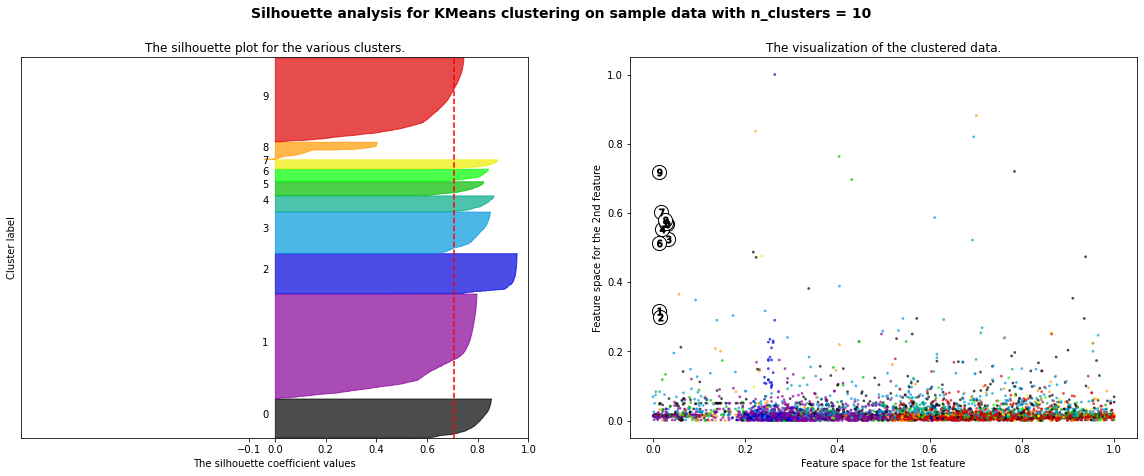

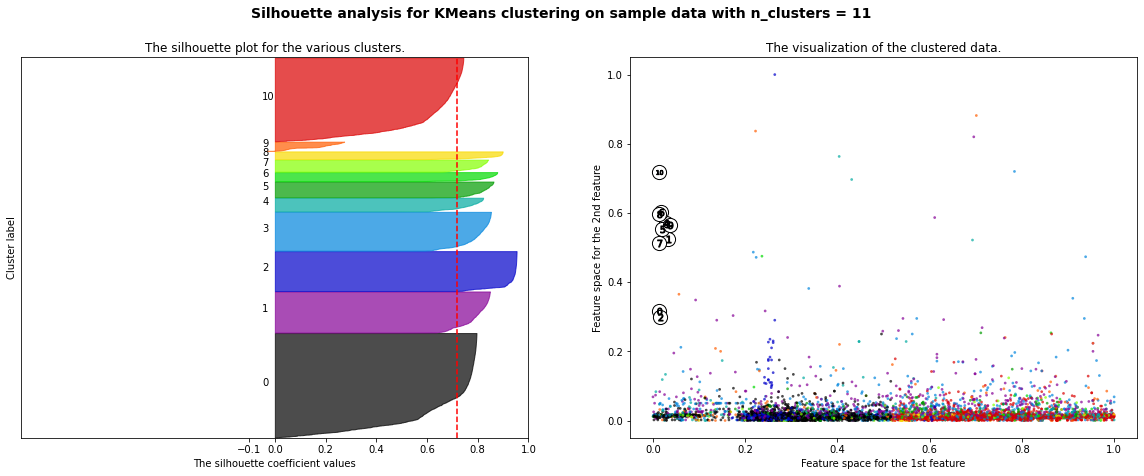

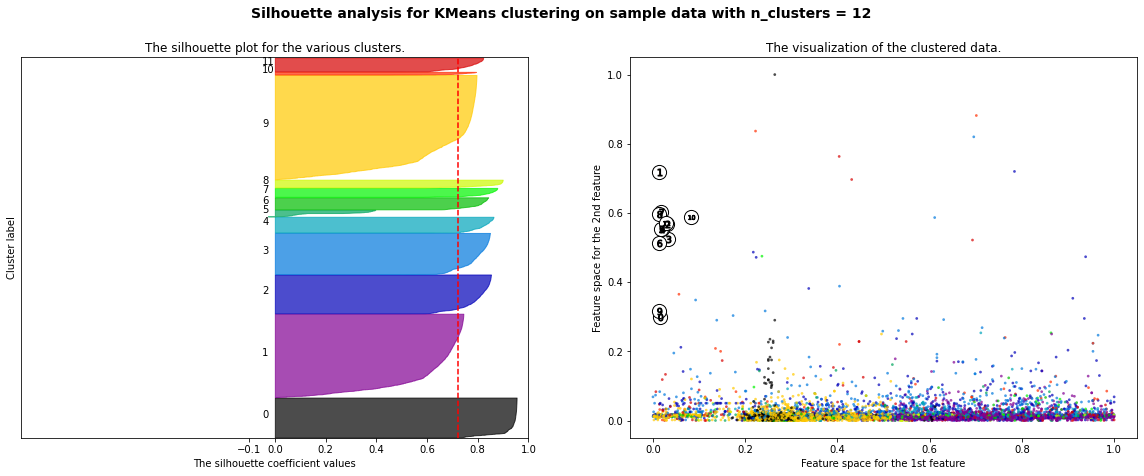

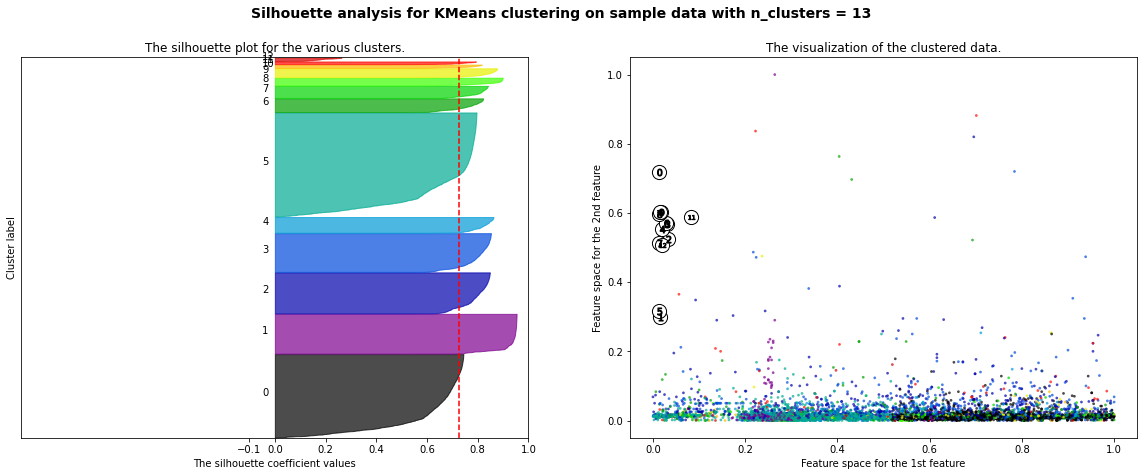

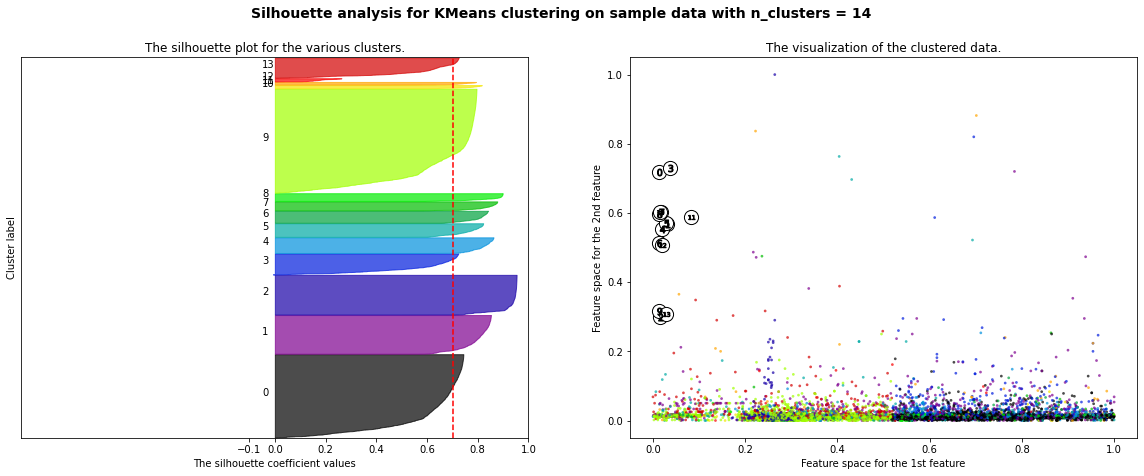

In [93]:
X, y = incident_dummy['Time_in_hours'], incident_dummy['Min_Delay']

for k in range(2,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(incident_dummy)
    cluster_labels = clusterer.predict(incident_dummy)
    
    silhouette_avg = silhouette_score(incident_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(incident_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        incident_dummy['Time_in_hours'], incident_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

### K-Means (day, location, incident)

In [94]:
DLI_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Min_Gap'], axis=1)
DLI_data

Day                       Location             Incident
242    Saturday                          ronce           mechanical
479      Sunday                 jameson_/_king           mechanical
994   Wednesday   howard_park_and_roncesvalles           mechanical
998    Thursday               queen/parliament           mechanical
346      Friday         queen_and_roncesvalles  late_leaving_garage
...         ...                            ...                  ...
335      Monday                   main_station  late_leaving_garage
643      Monday                   russell_yard           mechanical
774      Friday                     fleet_loop   emergency_services
631      Monday  coxwell_north_of_gerrard_east   emergency_services
1246     Monday              queen_&_connaught           mechanical

[8957 rows x 3 columns]

In [95]:
#encoded df
DLI_dummy = df

for i in DLI_data:
    dummies = pd.get_dummies(DLI_data[i])
    DLI_dummy = pd.concat([DLI_dummy, dummies], axis=1)
    DLI_dummy = DLI_dummy.drop(i, axis=1)

DLI_dummy = DLI_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route',
                            'Time_in_minutes','Direction', 'Min_Gap'], axis=1)

DLI_dummy['Min_Delay'] = (DLI_dummy['Min_Delay'] - DLI_dummy['Min_Delay'].min()) / (DLI_dummy['Min_Delay'].max() - DLI_dummy['Min_Delay'].min())
DLI_dummy['Time_in_hours'] = (DLI_dummy['Time_in_hours'] - DLI_dummy['Time_in_hours'].min()) / (DLI_dummy['Time_in_hours'].max() - DLI_dummy['Time_in_hours'].min())

DLI_dummy


Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
242    0.010000       0.343294       0       0         1       0         0   
479    0.013333       0.785962       0       0         0       1         0   
994    0.010000       0.259903       0       0         0       0         0   
998    0.015000       0.043780       0       0         0       0         1   
346    0.008333       0.254343       1       0         0       0         0   
...         ...            ...     ...     ...       ...     ...       ...   
335    0.006667       0.296734       0       1         0       0         0   
643    0.006667       0.259903       0       1         0       0         0   
774    0.015000       0.036136       1       0         0       0         0   
631    0.013333       0.586518       0       1         0       0         0   
1246   0.008333       0.298819       0       1         0       0         0   

      Tuesday  Wednesday  1st_and_lakeshore  ...  investigation  late  \
242         0          0                  0  ...              0     0   
479         0          0                  0  ...              0     0   
994         0          1                  0  ...              0     0   
998         0          0                  0  ...              0     0   
346         0          0                  0  ...              0     0   
...       ...        ...                ...  ...            ...   ...   
335         0          0                  0  ...              0     0   
643         0          0                  0  ...              0     0   
774         0          0                  0  ...              0     0   
631         0          0                  0  ...              0     0   
1246        0          0                  0  ...              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
242                     0           1           0         0   
479                     0           1           0         0   
994                     0           1           0         0   
998                     0           1           0         0   
346                     1           0           0         0   
...                   ...         ...         ...       ...   
335                     1           0           0         0   
643                     0           1           0         0   
774                     0           0           0         0   
631                     0           0           0         0   
1246                    0           1           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
242                       0              0         0                   0  
479                       0              0         0                   0  
994                       0              0         0                   0  
998                       0              0         0                   0  
346                       0              0         0                   0  
...                     ...            ...       ...                 ...  
335                       0              0         0                   0  
643                       0              0         0                   0  
774                       0              0         0                   0  
631                       0              0         0                   0  
1246                      0              0         0                   0  

[8957 rows x 2881 columns]

For k = 5 The average silhouette_score is : 0.1258934462802099
For k = 6 The average silhouette_score is : 0.12847797966610625
For k = 7 The average silhouette_score is : 0.2040781544449781
For k = 8 The average silhouette_score is : 0.19192755445909873
For k = 9 The average silhouette_score is : 0.17992315859834465
For k = 10 The average silhouette_score is : 0.16920844476746247
For k = 11 The average silhouette_score is : 0.1560023769245539
For k = 12 The average silhouette_score is : 0.1590903101539385
For k = 13 The average silhouette_score is : 0.16601099154399368
For k = 14 The average silhouette_score is : 0.1665902523844995


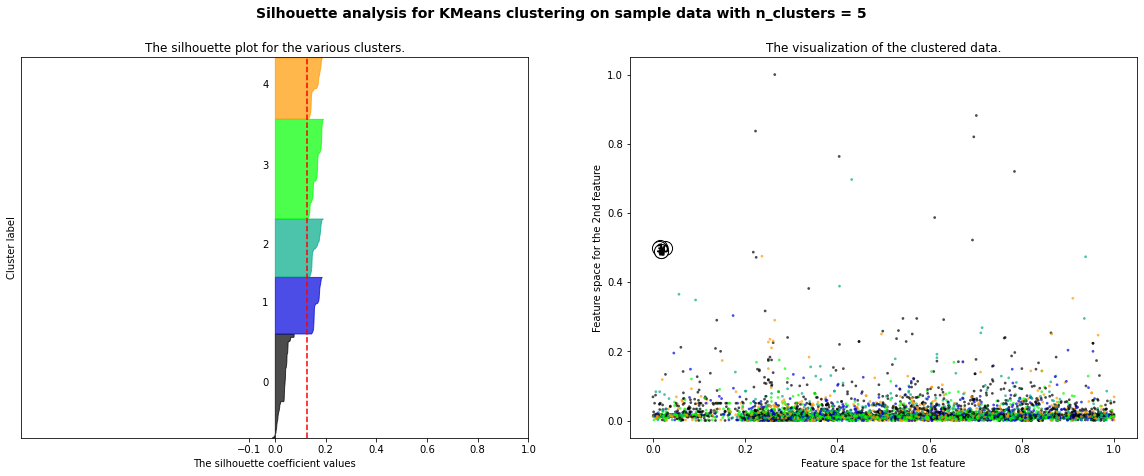

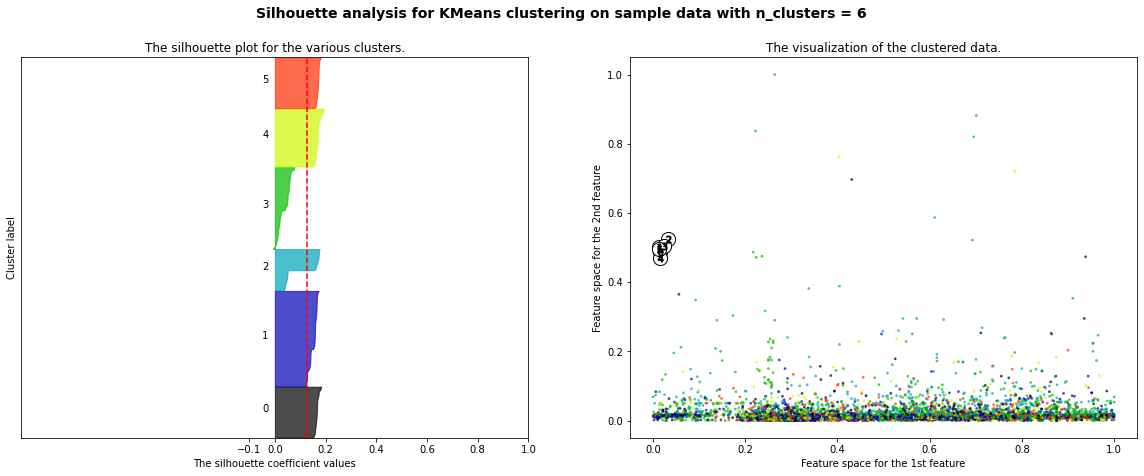

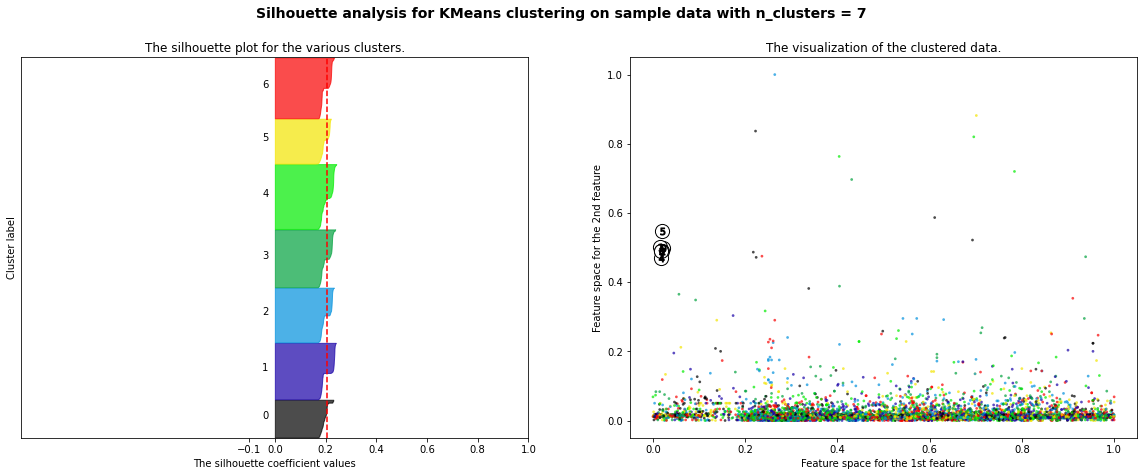

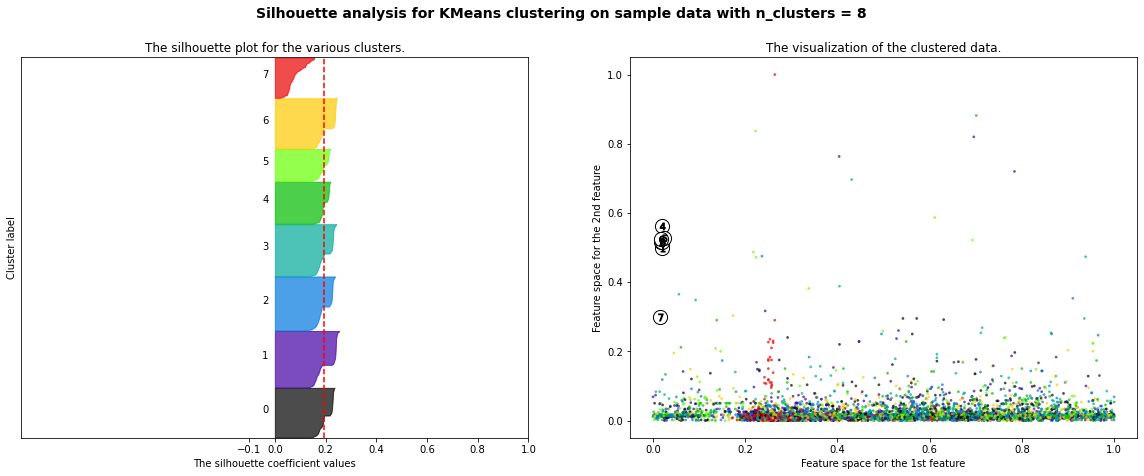

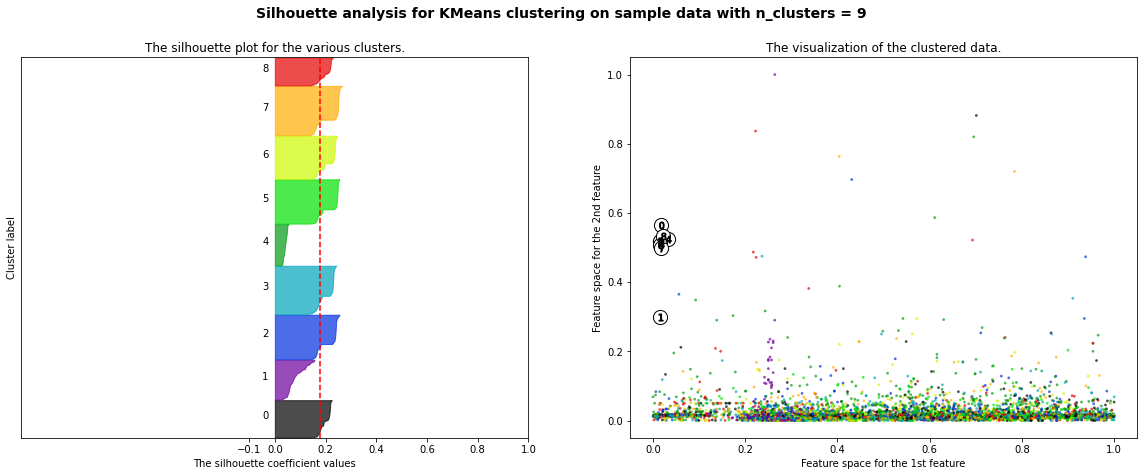

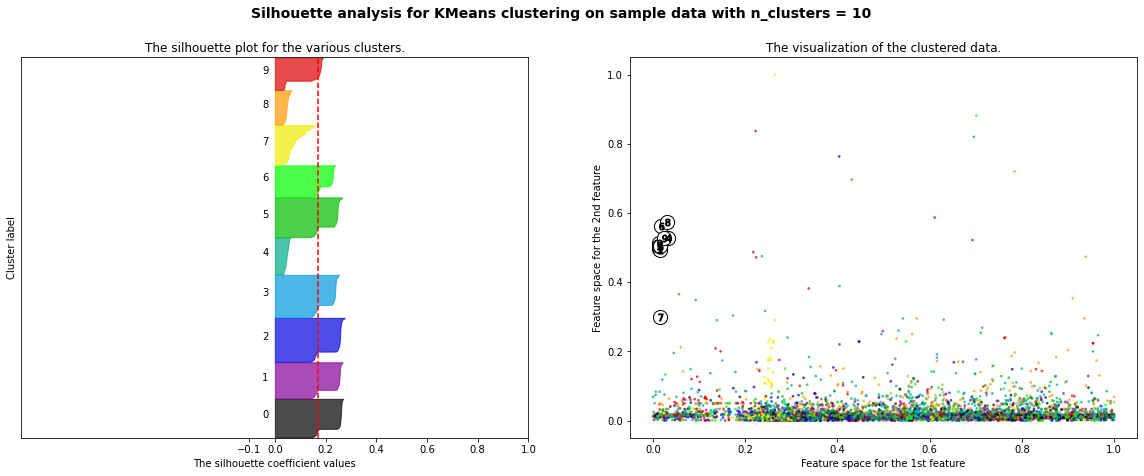

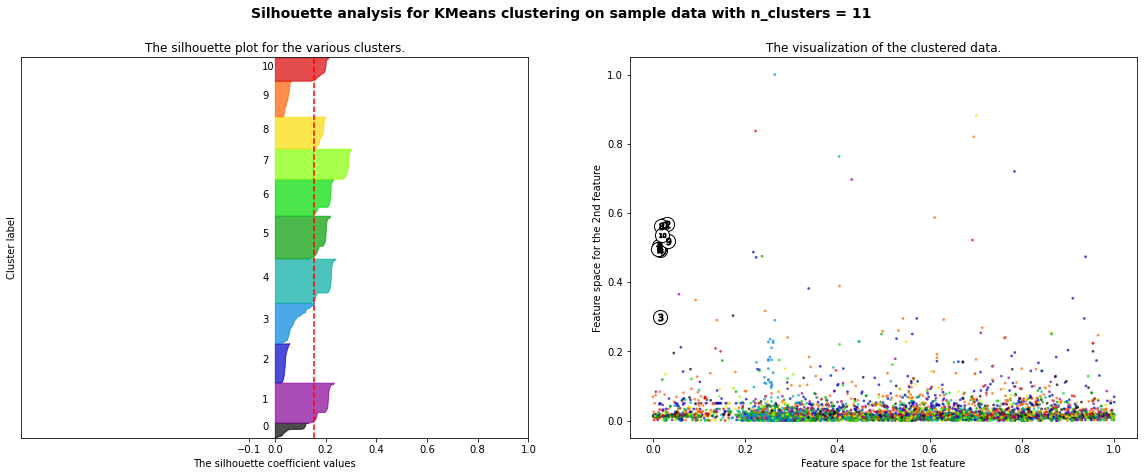

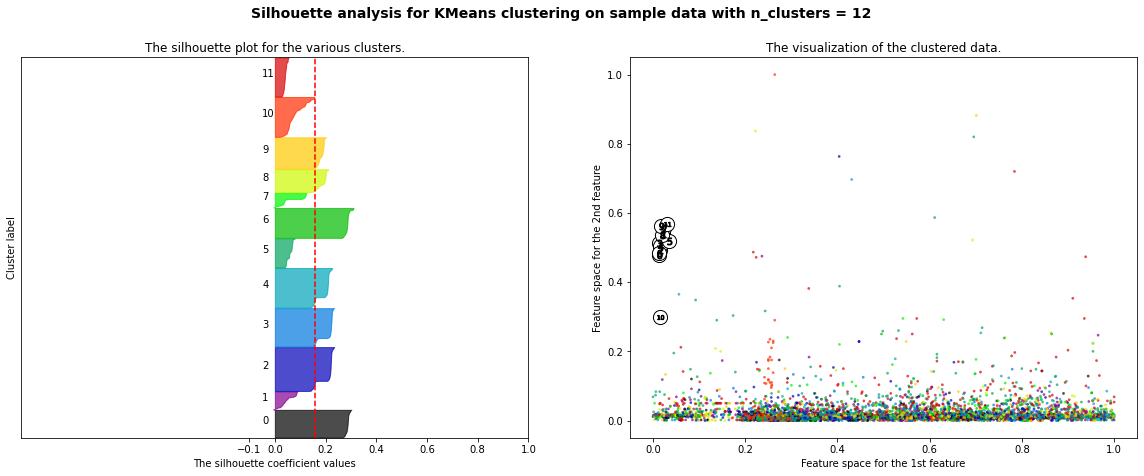

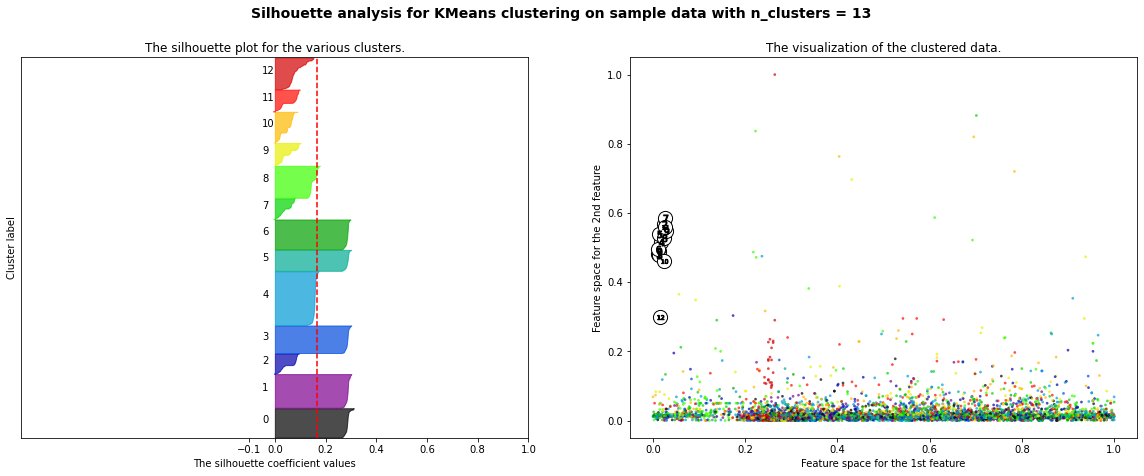

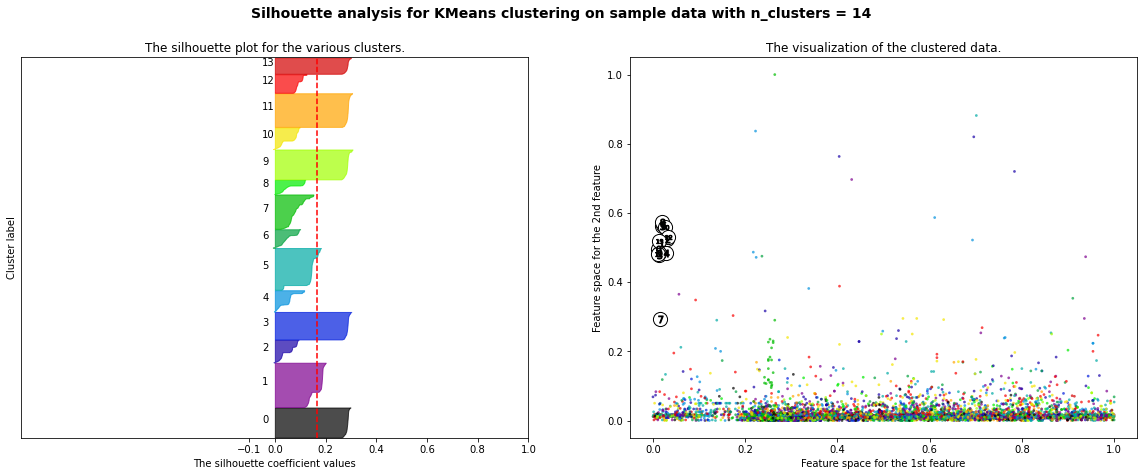

In [96]:
X, y = DLI_dummy['Time_in_hours'], DLI_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DLI_dummy)
    cluster_labels = clusterer.predict(DLI_dummy)
    
    silhouette_avg = silhouette_score(DLI_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(DLI_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        DLI_dummy['Time_in_hours'], DLI_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

In [47]:
# Try various values of k
sil_scores = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DLI_dummy)
    label = clusterer.predict(DLI_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(DLI_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] 
best_label

# Present some summary statistics for each clusters
#location_dummy.groupby(best_label).mean()
sil_scores

k  silhouette_score                                              label
0   5          0.127660  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
1   6          0.130993  [3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, ...
2   7          0.204078  [6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, ...
3   8          0.191928  [6, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, ...
4   9          0.180756  [0, 8, 8, 3, 8, 8, 8, 3, 1, 1, 1, 1, 1, 1, 1, ...
5  10          0.168843  [0, 8, 2, 4, 8, 2, 8, 4, 6, 6, 6, 6, 6, 6, 6, ...
6  11          0.160750  [8, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, ...
7  12          0.159911  [2, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 1...
8  13          0.161566  [8, 3, 1, 11, 3, 1, 3, 11, 10, 2, 2, 2, 2, 2, ...
9  14          0.168517  [4, 4, 6, 4, 4, 6, 4, 4, 13, 1, 1, 1, 1, 1, 1,...

### K-Means (day and incident)

In [99]:
DI_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction', 'Location',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Min_Gap'], axis=1)
DI_data

Day             Incident
242    Saturday           mechanical
479      Sunday           mechanical
994   Wednesday           mechanical
998    Thursday           mechanical
346      Friday  late_leaving_garage
...         ...                  ...
335      Monday  late_leaving_garage
643      Monday           mechanical
774      Friday   emergency_services
631      Monday   emergency_services
1246     Monday           mechanical

[8957 rows x 2 columns]

In [100]:
#encoded df
DI_dummy = df

for i in DI_data:
    dummies = pd.get_dummies(DI_data[i])
    DI_dummy = pd.concat([DI_dummy, dummies], axis=1)
    DI_dummy = DI_dummy.drop(i, axis=1)

DI_dummy = DI_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route',
                          'Time_in_minutes','Direction', 'Min_Gap', 'Location'], axis=1)

DI_dummy['Min_Delay'] = (DI_dummy['Min_Delay'] - DI_dummy['Min_Delay'].min()) / (DI_dummy['Min_Delay'].max() - DI_dummy['Min_Delay'].min())
DI_dummy['Time_in_hours'] = (DI_dummy['Time_in_hours'] - DI_dummy['Time_in_hours'].min()) / (DI_dummy['Time_in_hours'].max() - DI_dummy['Time_in_hours'].min())

DI_dummy


Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
242    0.010000       0.343294       0       0         1       0         0   
479    0.013333       0.785962       0       0         0       1         0   
994    0.010000       0.259903       0       0         0       0         0   
998    0.015000       0.043780       0       0         0       0         1   
346    0.008333       0.254343       1       0         0       0         0   
...         ...            ...     ...     ...       ...     ...       ...   
335    0.006667       0.296734       0       1         0       0         0   
643    0.006667       0.259903       0       1         0       0         0   
774    0.015000       0.036136       1       0         0       0         0   
631    0.013333       0.586518       0       1         0       0         0   
1246   0.008333       0.298819       0       1         0       0         0   

      Tuesday  Wednesday  cleaning  ...  investigation  late  \
242         0          0         0  ...              0     0   
479         0          0         0  ...              0     0   
994         0          1         0  ...              0     0   
998         0          0         0  ...              0     0   
346         0          0         0  ...              0     0   
...       ...        ...       ...  ...            ...   ...   
335         0          0         0  ...              0     0   
643         0          0         0  ...              0     0   
774         0          0         0  ...              0     0   
631         0          0         0  ...              0     0   
1246        0          0         0  ...              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
242                     0           1           0         0   
479                     0           1           0         0   
994                     0           1           0         0   
998                     0           1           0         0   
346                     1           0           0         0   
...                   ...         ...         ...       ...   
335                     1           0           0         0   
643                     0           1           0         0   
774                     0           0           0         0   
631                     0           0           0         0   
1246                    0           1           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
242                       0              0         0                   0  
479                       0              0         0                   0  
994                       0              0         0                   0  
998                       0              0         0                   0  
346                       0              0         0                   0  
...                     ...            ...       ...                 ...  
335                       0              0         0                   0  
643                       0              0         0                   0  
774                       0              0         0                   0  
631                       0              0         0                   0  
1246                      0              0         0                   0  

[8957 rows x 25 columns]

In [101]:
# Try various values of k
sil_scores = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DI_dummy)
    label = clusterer.predict(DI_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(DI_dummy, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] 
best_label

# Present some summary statistics for each clusters
#location_dummy.groupby(best_label).mean()
sil_scores

k  silhouette_score                                              label
0   5          0.308589  [0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 4, 3, 2, 0, ...
1   6          0.364101  [2, 2, 3, 4, 0, 2, 3, 2, 2, 4, 2, 5, 1, 4, 3, ...
2   7          0.406939  [6, 3, 2, 4, 5, 3, 2, 6, 3, 4, 6, 1, 0, 4, 2, ...
3   8          0.373836  [6, 7, 5, 1, 3, 7, 0, 6, 7, 1, 6, 4, 2, 1, 0, ...
4   9          0.391578  [5, 6, 4, 0, 2, 6, 7, 5, 6, 0, 5, 3, 1, 0, 7, ...
5  10          0.408305  [6, 7, 8, 3, 4, 9, 0, 6, 7, 9, 4, 5, 1, 3, 0, ...
6  11          0.409925  [3, 4, 5, 8, 2, 10, 9, 3, 4, 10, 2, 6, 0, 8, 9...
7  12          0.438537  [11, 3, 1, 10, 9, 3, 5, 11, 3, 8, 9, 6, 7, 10,...
8  13          0.447517  [4, 7, 6, 5, 8, 12, 2, 4, 7, 9, 8, 3, 1, 5, 2,...
9  14          0.450800  [11, 4, 5, 8, 13, 4, 10, 11, 4, 8, 1, 7, 2, 8,...

For k = 5 The average silhouette_score is : 0.26999418804966746
For k = 6 The average silhouette_score is : 0.3070935104531505
For k = 7 The average silhouette_score is : 0.34203597934724733
For k = 8 The average silhouette_score is : 0.3767394433539852
For k = 9 The average silhouette_score is : 0.4007341473500504
For k = 10 The average silhouette_score is : 0.4032622833872013
For k = 11 The average silhouette_score is : 0.41519397826061655
For k = 12 The average silhouette_score is : 0.4273418892514996
For k = 13 The average silhouette_score is : 0.44417946886114756
For k = 14 The average silhouette_score is : 0.44791193763659165
For k = 15 The average silhouette_score is : 0.48795109487579313
For k = 16 The average silhouette_score is : 0.49594474073267436
For k = 17 The average silhouette_score is : 0.5046636961253376
For k = 18 The average silhouette_score is : 0.5207671517802549
For k = 19 The average silhouette_score is : 0.5361822316871844


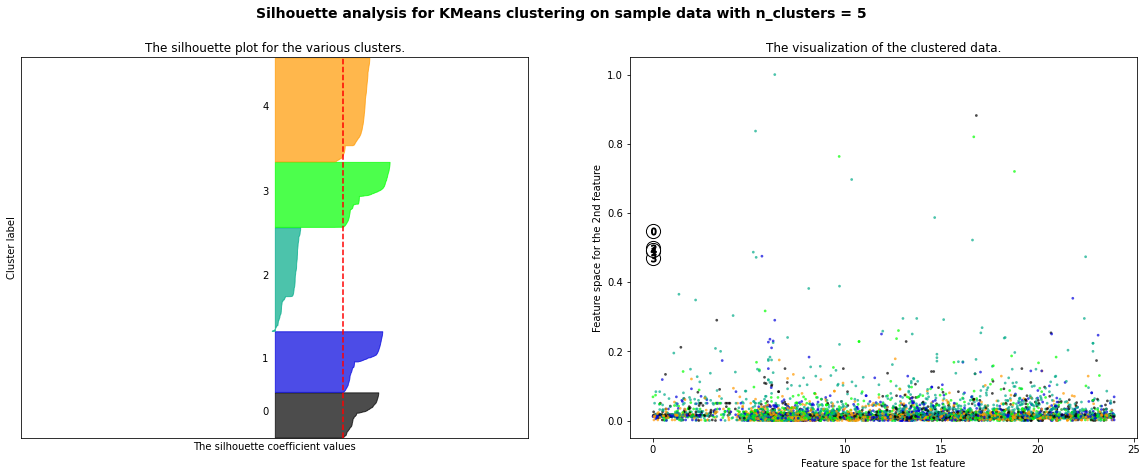

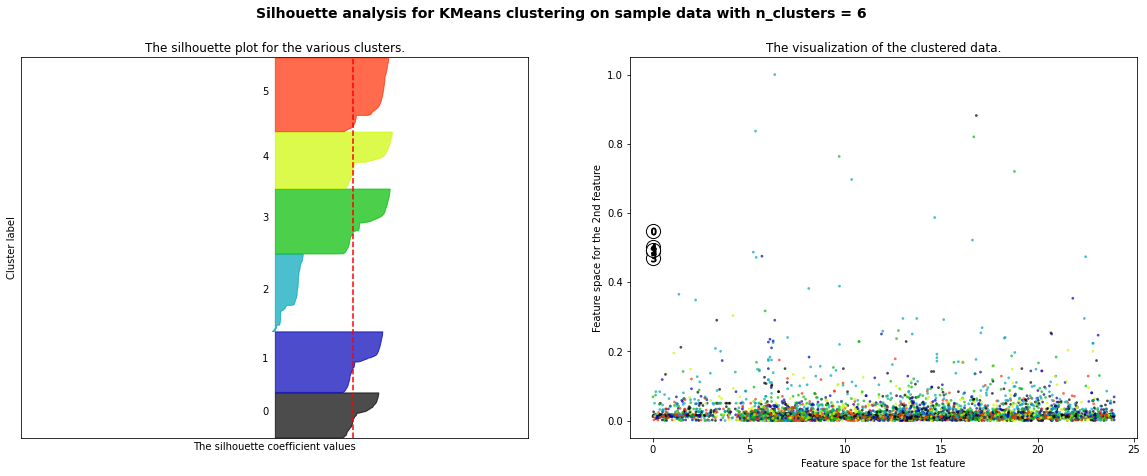

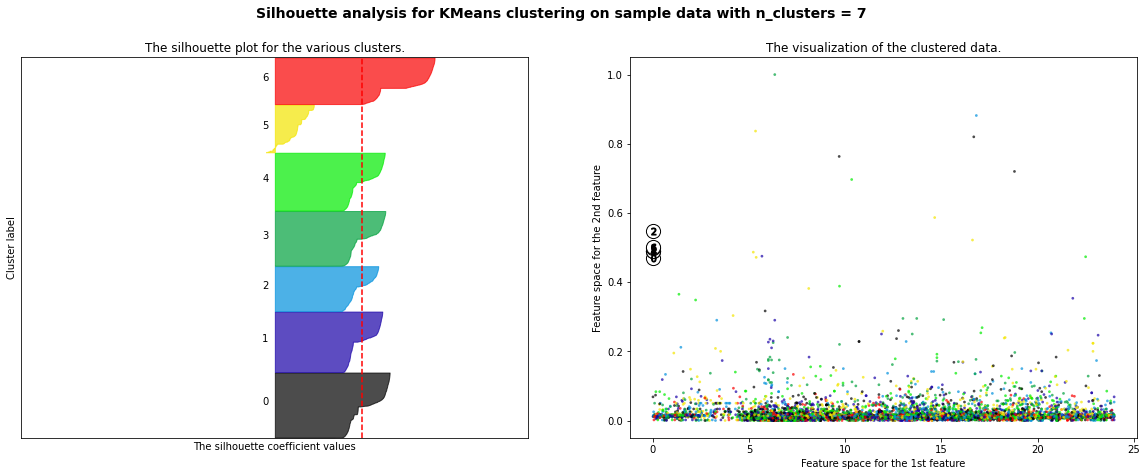

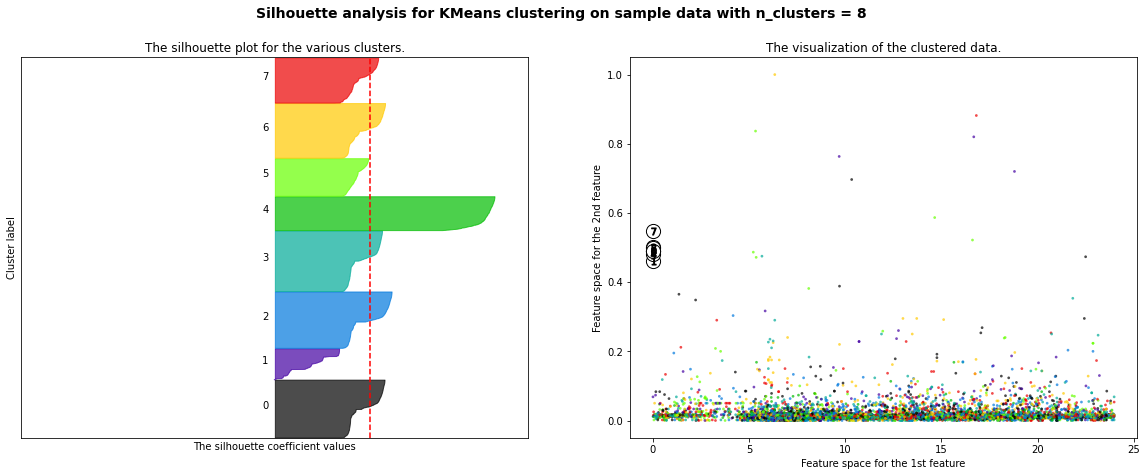

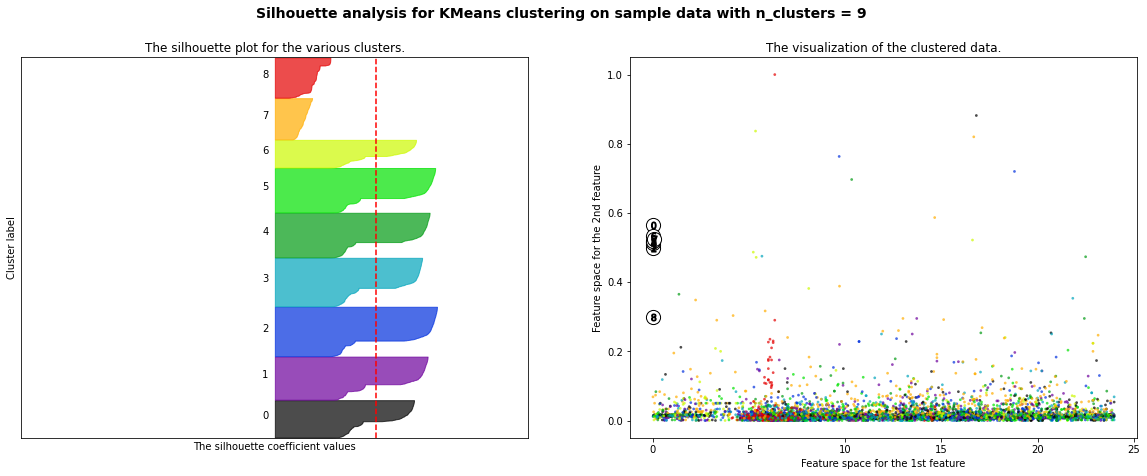

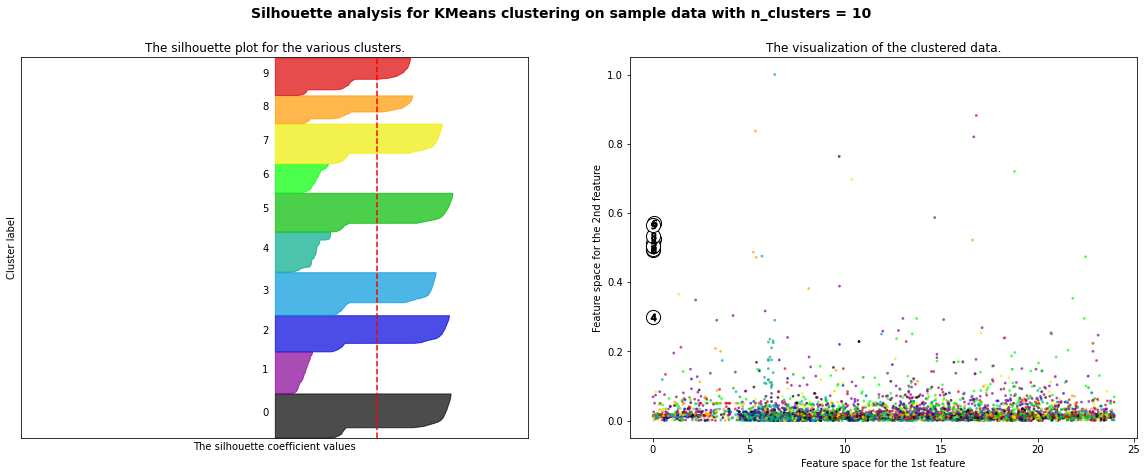

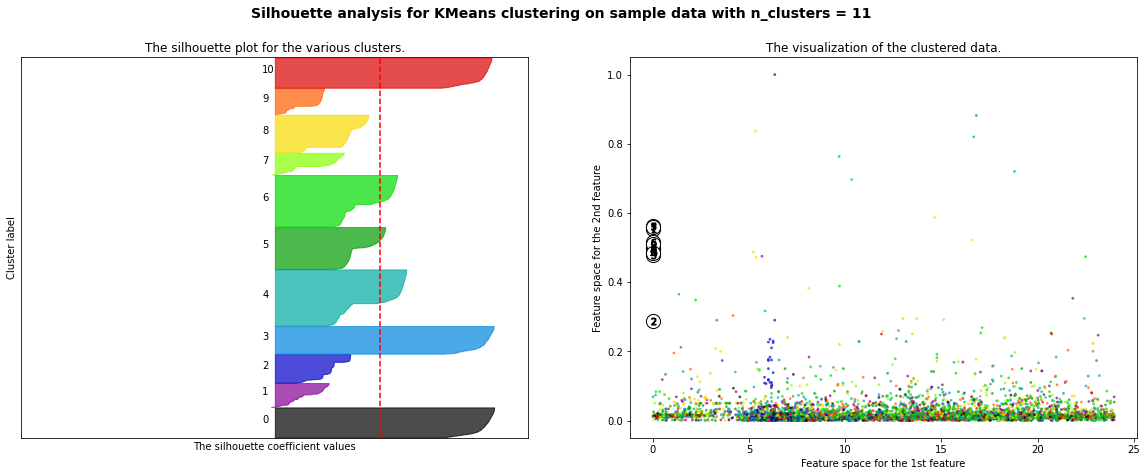

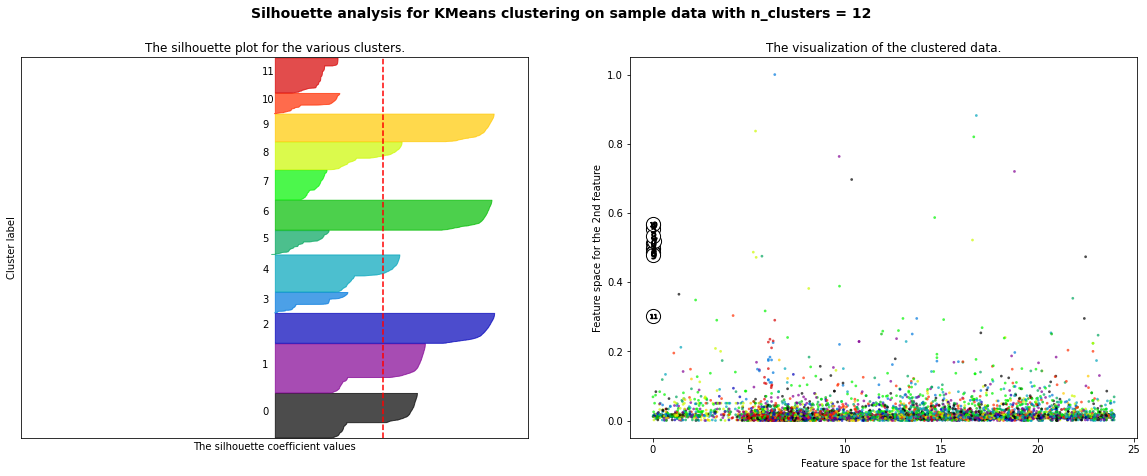

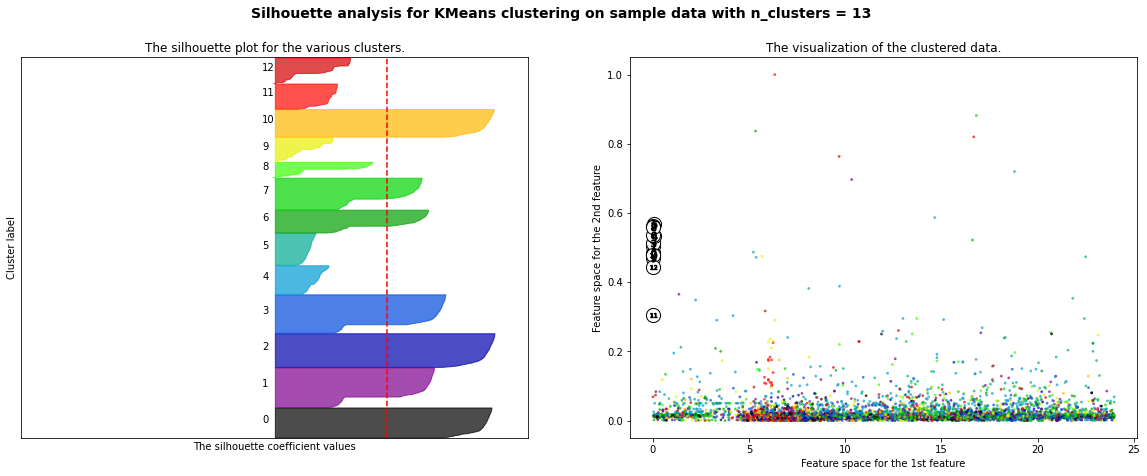

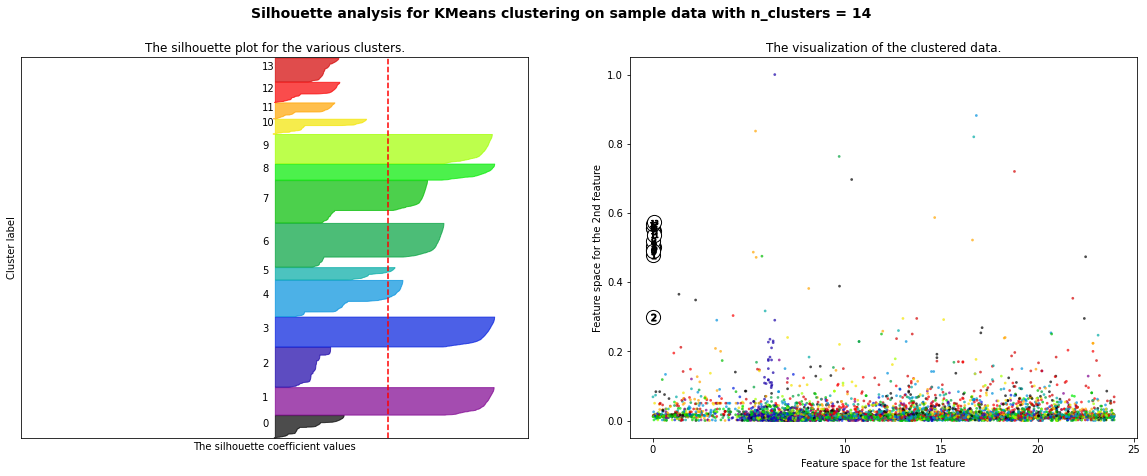

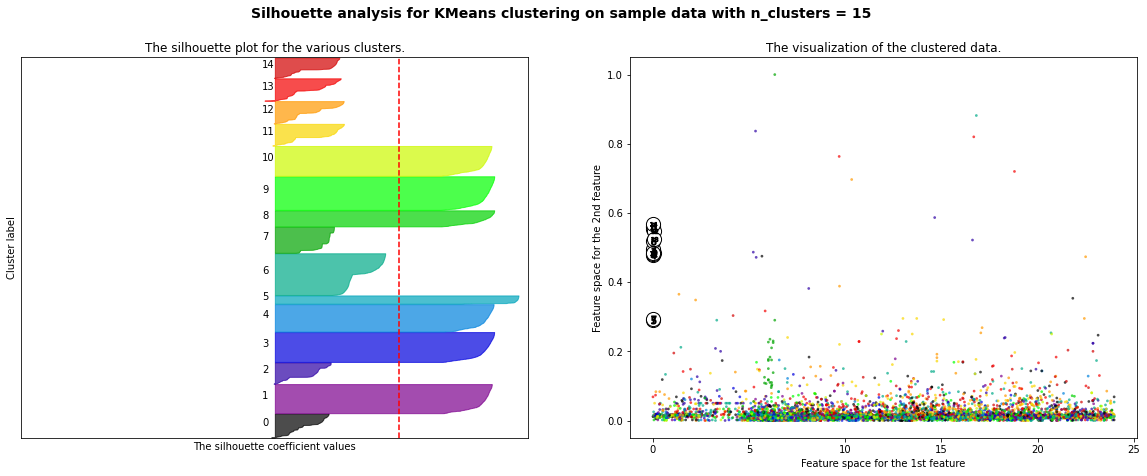

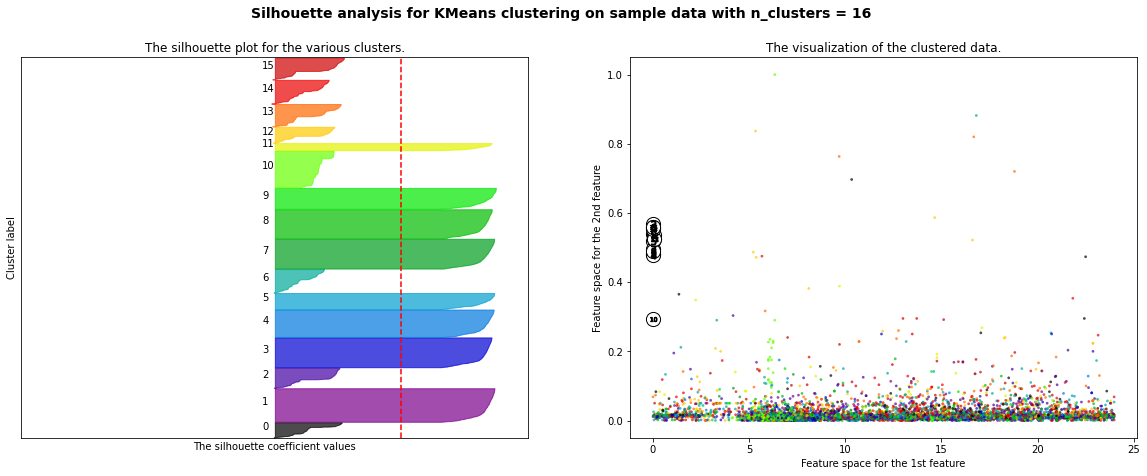

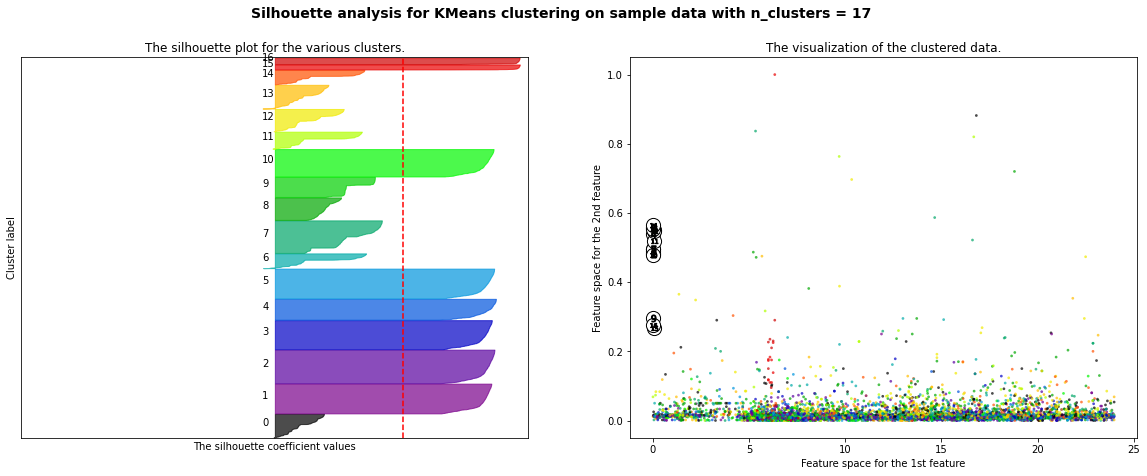

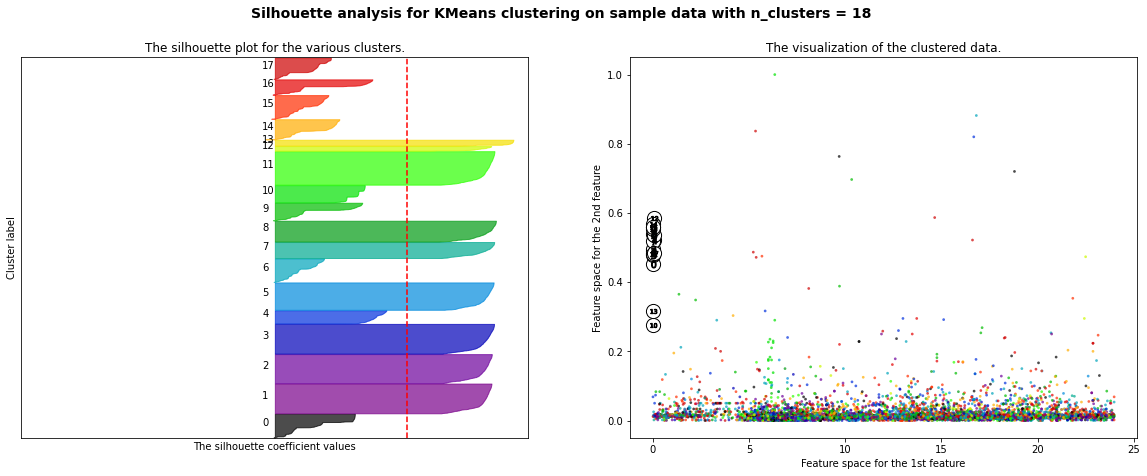

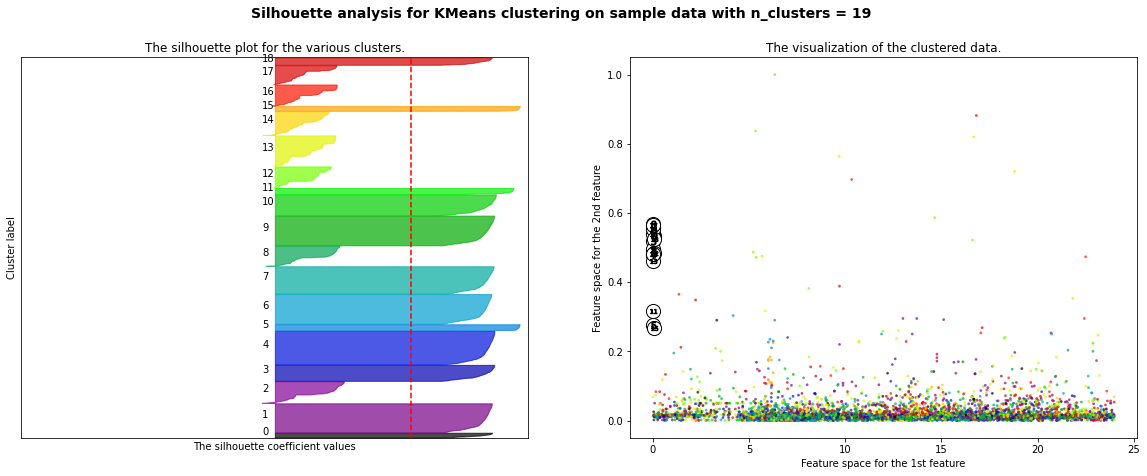

In [111]:
X, y = df['Time_in_hours'], DI_dummy['Min_Delay']

for k in range(5,20):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(DI_dummy)
    cluster_labels = clusterer.predict(DI_dummy)
    
    silhouette_avg = silhouette_score(DI_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(DI_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        df['Time_in_hours'],DI_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    